# Aligned Baselines

Goal: investigate the agreement between integrated gradients and activation patching when the baselines are similar, across a variety of circuit tasks.

- Indirect Object Identification (Wang et al, 2023): consists of inputs like “When Mary and John went to the store, John gave a bottle of milk to”; models are expected to predict “Mary”. Performance measured using logit differences.

- Gender-Bias (Vig et al, 2020): designed to study gender bias in LMs. Gives models inputs like “The nurse said that”; biased models tend to complete this sentence with “she”. Performance measured using logit differences.

- Greater-Than (Hanna et al., 2023): models receive input like “The war lasted from the year 1741 to the year 17”, and must predict a valid two-digit end year, i.e. one that is greater than 41. Performance measured using probability differences.

- Capital–Country (Hanna et al., 2024): models receive input like “Tirana, the capital of” and must output the corresponding country (Albania). Corrupted instances contain another capital (e.g. Brasilia) instead. Performance measured using logit differences.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.utils import get_device

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, greater_than_prob_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance, print_jaccard_multi
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart, plot_mean_diff

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Indirect Object Identification

### Case study

In [5]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to"
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to"
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([3.5417], device='cuda:0')
Corrupted logit difference: tensor([-4.8407], device='cuda:0')


In [6]:
case_ap_mlp, case_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(case_ap_mlp, "results/aligned/ioi/case_ap_mlp.pt")
torch.save(case_ap_attn, "results/aligned/ioi/case_ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [3]:
case_ig_mlp = torch.load("results/case_study/mlp_corrupt_clean.pt")
case_ig_attn = torch.load("results/case_study/attn_corrupt_clean.pt")

case_ap_mlp = torch.load("results/aligned/ioi/case_ap_mlp.pt")
case_ap_attn = torch.load("results/aligned/ioi/case_ap_attn.pt")

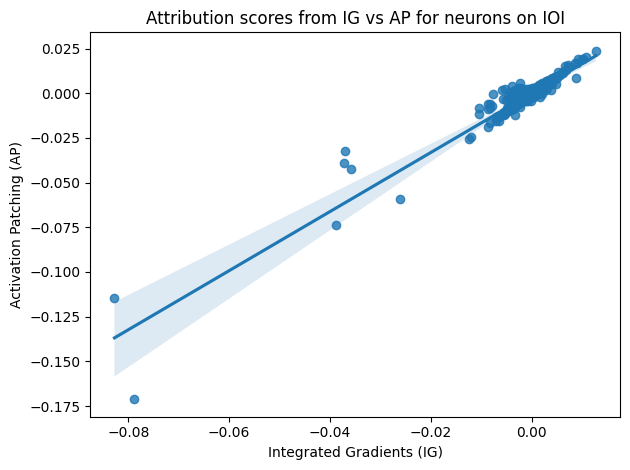

Correlation coefficient: 0.9520487991302579


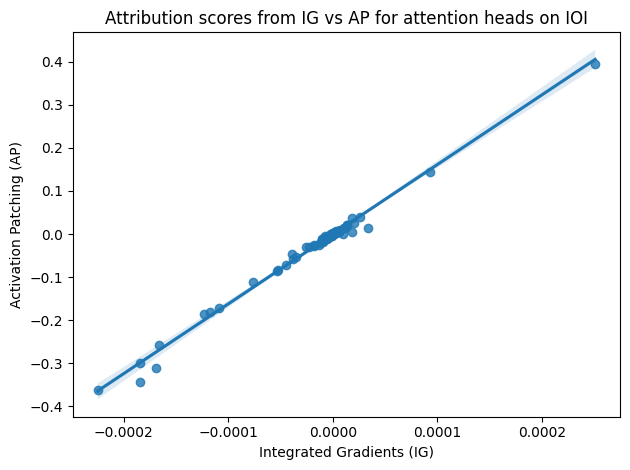

Correlation coefficient: 0.9952197197592786


In [4]:
plot_correlation(
    case_ig_mlp, case_ap_mlp,
    "Integrated Gradients (IG)", "Activation Patching (AP)",
    "Attribution scores from IG vs AP for neurons on IOI"
)
plot_correlation(
    case_ig_attn, case_ap_attn, 
    "Integrated Gradients (IG)", "Activation Patching (AP)",
    "Attribution scores from IG vs AP for attention heads on IOI"
)

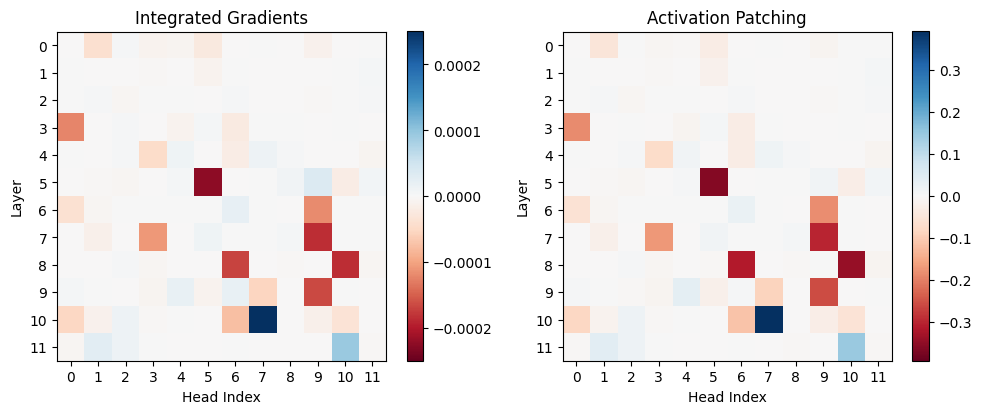

In [8]:
plot_attn_comparison(case_ig_attn[:1], case_ap_attn[:1], model)

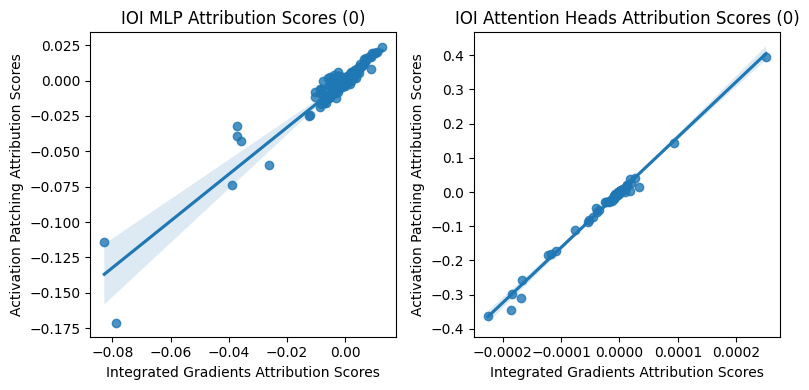

Correlation coefficient for neurons: 0.9520487991302581
Correlation coefficient for attention heads: 0.9952197197592786


In [9]:
plot_correlation_comparison(case_ig_mlp[:1], case_ap_mlp[:1], case_ig_attn[:1], case_ap_attn[:1], Task.IOI)

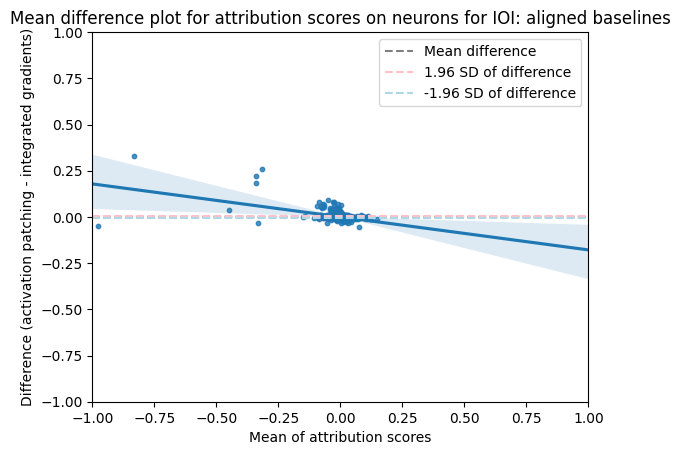

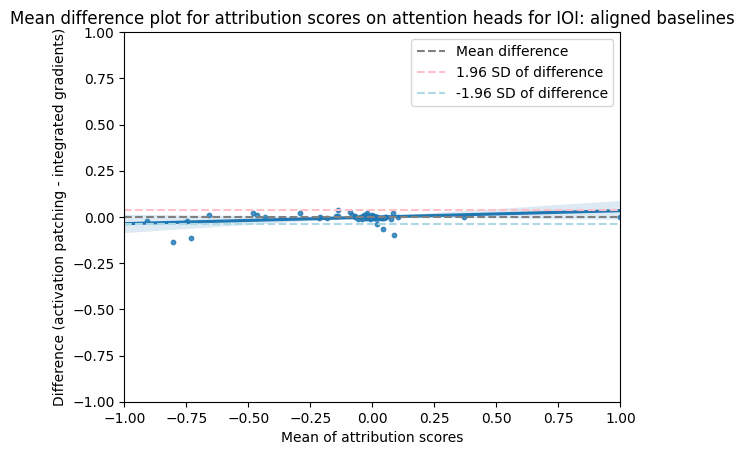

In [28]:
plot_mean_diff(case_ig_mlp, case_ap_mlp, "Mean difference plot for attribution scores on neurons for IOI: aligned baselines")
plot_mean_diff(case_ig_attn, case_ap_attn, "Mean difference plot for attribution scores on attention heads for IOI: aligned baselines")

### Experiment

In [3]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [4]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

ioi_ig_zero_mlp, ioi_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, clean_cache, logit_diff_metric, labels)

torch.save(ioi_ig_zero_mlp, "results/aligned/ioi/ig_zero_mlp.pt")
torch.save(ioi_ig_zero_attn, "results/aligned/ioi/ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.3117e-01,  3.6102e-02, -3.0719e-01,  2.1320e-01,  1.8795e-01,
        -4.3097e-01, -3.7518e-01,  2.7115e-01,  4.4686e+00, -1.1150e-01,
        -1.7191e-01,  5.8448e-01,  3.4518e+00, -8.2562e-02,  6.8106e-01,
         3.3526e-01, -9.9698e-02,  3.0928e-01,  3.7595e-01, -1.1244e-01,
        -1.4868e-02,  4.3999e-01,  1.7113e-02,  2.0678e-01,  2.1274e-01,
         2.7953e-01,  4.3948e-01, -6.1429e-02, -5.2967e-01,  2.0603e-01,
         2.9338e-02,  2.4162e-01, -2.7459e-01, -2.4940e-02,  2.8342e-01,
         2.9081e-01,  1.1620e-01,  5.3059e-02, -2.7999e-02,  2.2944e-01,
         2.6297e-01, -4.7922e+00,  1.0546e+00, -9.8640e-02,  6.1137e-01,
         1.4469e-01, -2.5010e-01, -1.0046e+00, -1.4854e-01, -1.1812e+00,
        -3.2850e+00,  9.1023e-02,  1.2862e+01,  1.8781e-01, -6.6630e+00,
         1.4640e-01,  1.0590e+00, -3.0905e-01,  9.6648e-02, -2.4374e-01,
        -1.6660e-01,  7.7175e+00, -2.0437e-01,  6.2080e-01, -5.352

In [ ]:
ioi_ig_mlp, ioi_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ioi_ig_mlp, "results/aligned/ioi/ig_mlp.pt")
torch.save(ioi_ig_attn, "results/aligned/ioi/ig_attn.pt")

In [6]:
ioi_ap_mlp, ioi_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(ioi_ap_mlp, "results/aligned/ioi/ap_mlp.pt")
torch.save(ioi_ap_attn, "results/aligned/ioi/ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

### Analysis

In [4]:
ioi_ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ioi_ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")
ioi_ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ioi_ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

In [8]:
assert ioi_ig_mlp.size(0) == ioi_ig_attn.size(0) == ioi_ap_mlp.size(0) == ioi_ap_attn.size(0)

In [5]:
print_jaccard_multi(ioi_ig_mlp, ioi_ig_attn, ioi_ap_mlp, ioi_ap_attn)

Average Jaccard similarity score for MLP: 0.8971133232116699
Average Jaccard similarity score for Attention: 0.9473195672035217
Jaccard similarity std for MLP: 0.09915415197610855
Jaccard similarity std for Attention: 0.18281637132167816


In [6]:
ioi_ig_zero_mlp = torch.load("results/aligned/ioi/ig_zero_mlp.pt")
ioi_ig_zero_attn = torch.load("results/aligned/ioi/ig_zero_attn.pt")

print("For zero baseline:")
print_jaccard_multi(ioi_ig_zero_mlp, ioi_ig_zero_attn, ioi_ap_mlp, ioi_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.15668156743049622
Average Jaccard similarity score for Attention: 0.27463918924331665
Jaccard similarity std for MLP: 0.04751163721084595
Jaccard similarity std for Attention: 0.4079735279083252


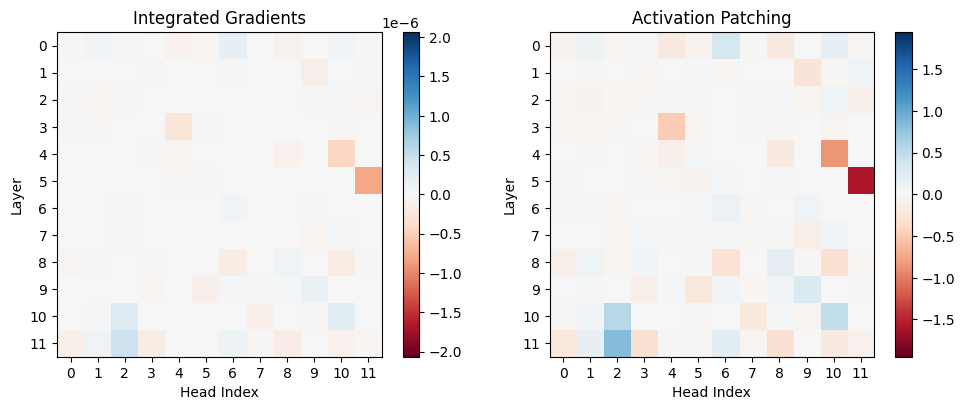

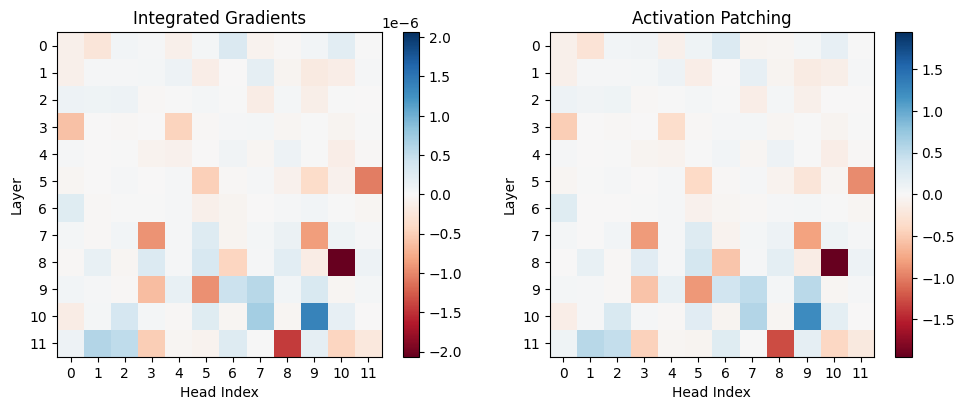

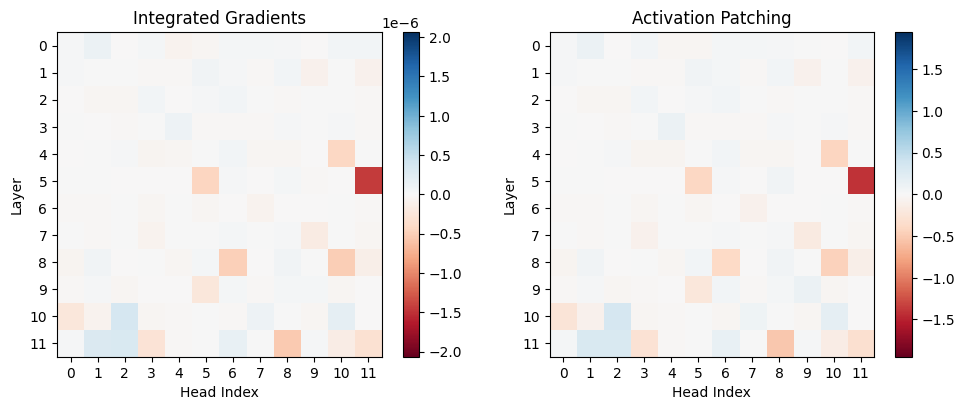

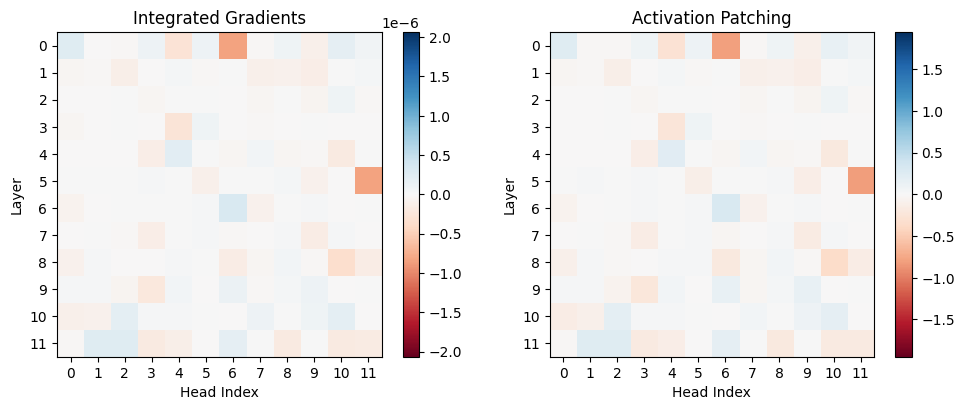

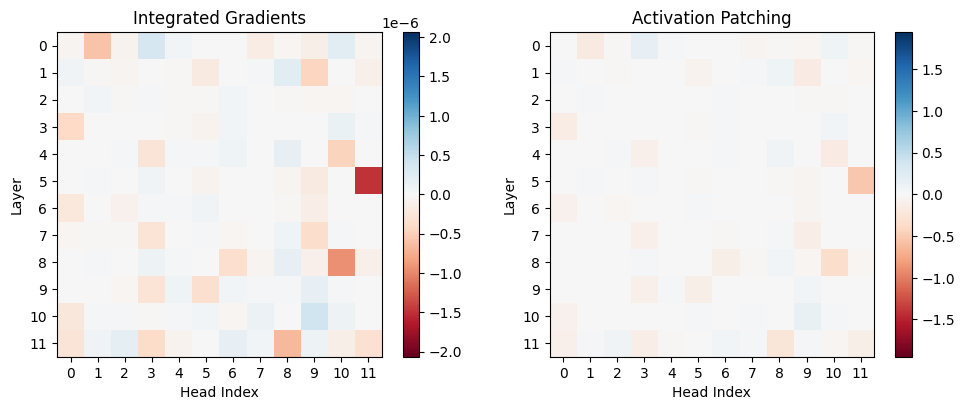

In [8]:
plot_attn_comparison(ioi_ig_attn[:5], ioi_ap_attn[:5], model)

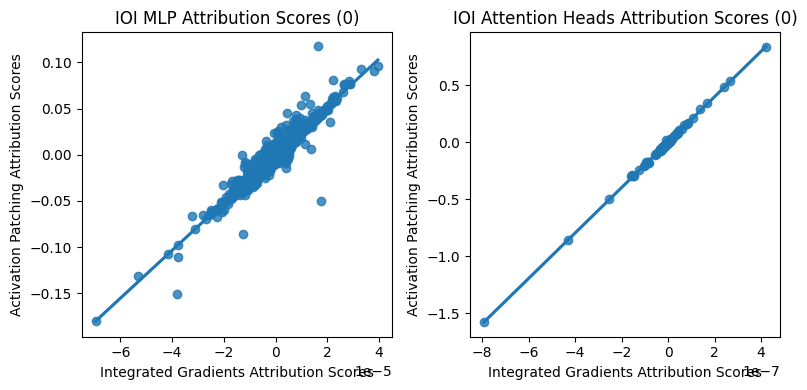

Correlation coefficient for neurons: 0.9781080393095625
Correlation coefficient for attention heads: 0.9996766519539676


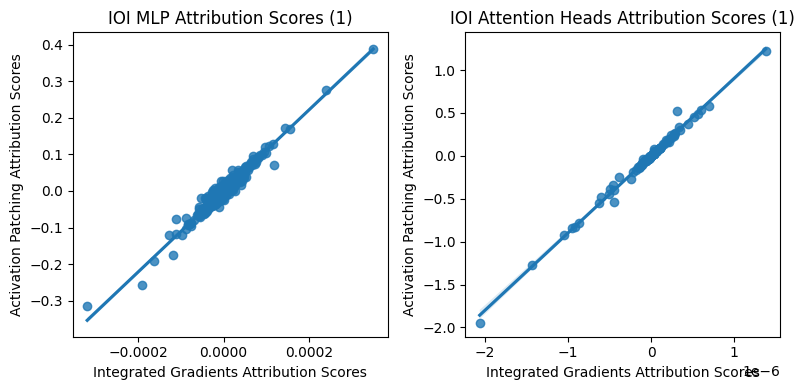

Correlation coefficient for neurons: 0.9806869207736839
Correlation coefficient for attention heads: 0.9951896333430784


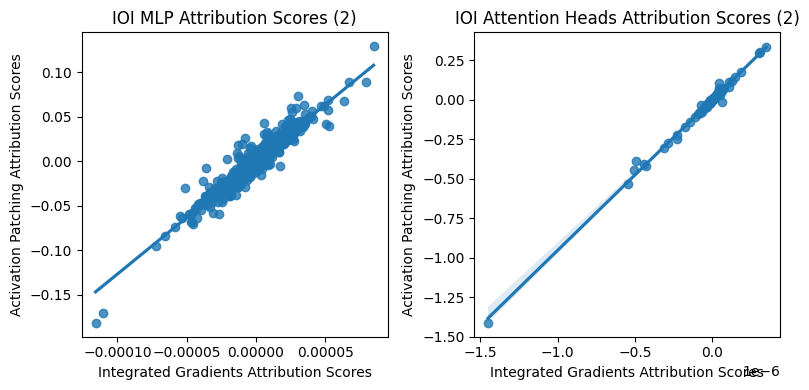

Correlation coefficient for neurons: 0.9757320311419594
Correlation coefficient for attention heads: 0.9967339352568454


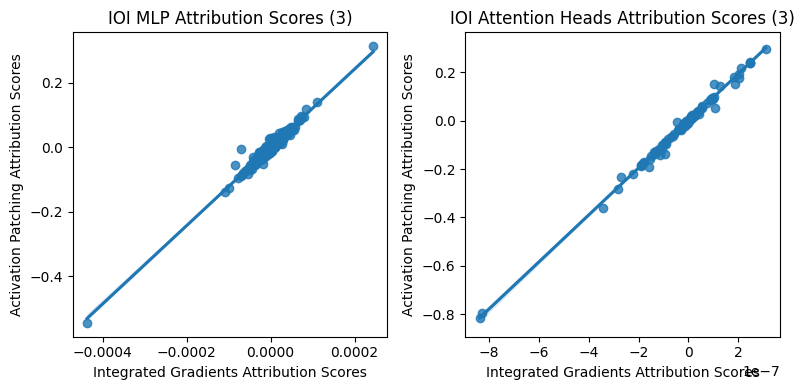

Correlation coefficient for neurons: 0.9839111497004037
Correlation coefficient for attention heads: 0.9967403119594924


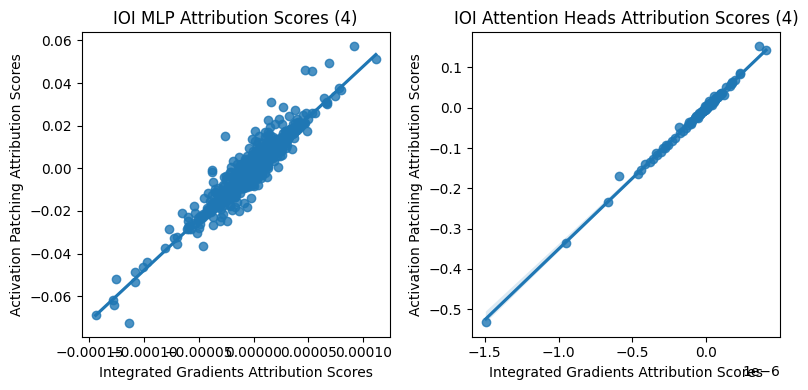

Correlation coefficient for neurons: 0.9670389843591409
Correlation coefficient for attention heads: 0.997777206804122


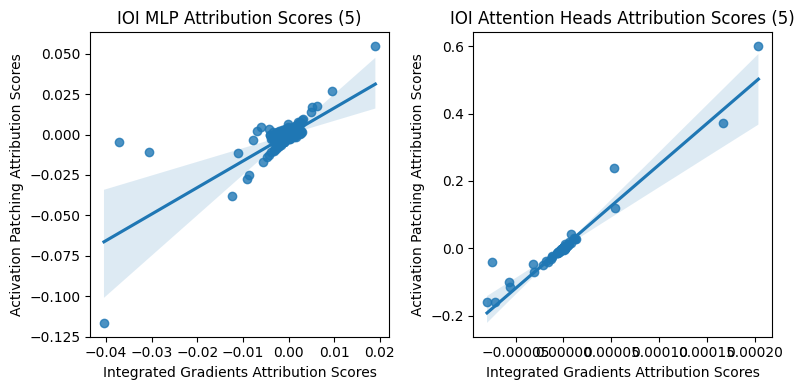

Correlation coefficient for neurons: 0.7595119694726896
Correlation coefficient for attention heads: 0.963231763268486


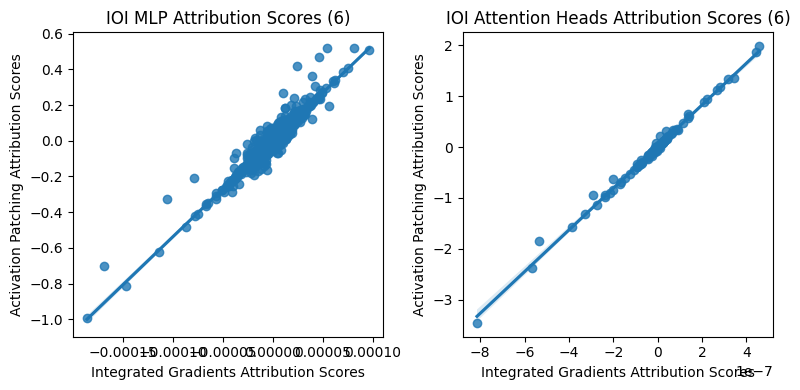

Correlation coefficient for neurons: 0.9741439068601965
Correlation coefficient for attention heads: 0.9965606172404634


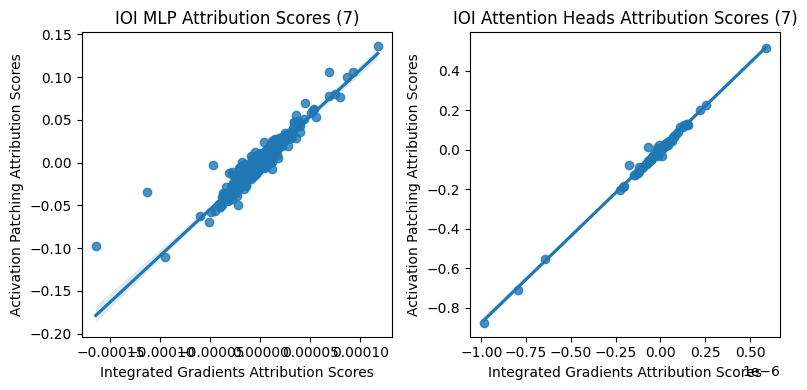

Correlation coefficient for neurons: 0.9665006507599821
Correlation coefficient for attention heads: 0.9964217682045792


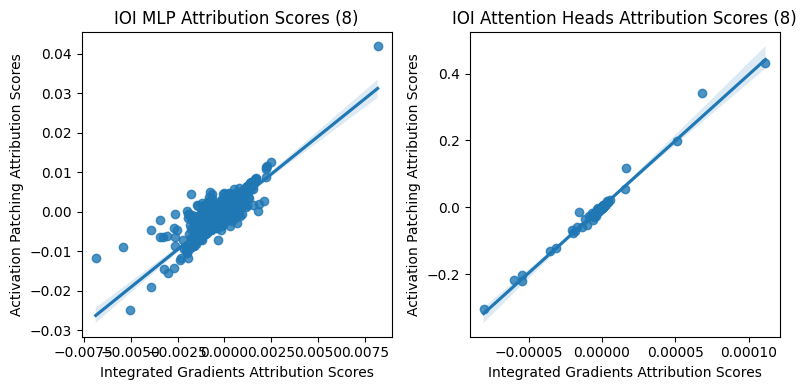

Correlation coefficient for neurons: 0.8802485892531234
Correlation coefficient for attention heads: 0.9904691626179392


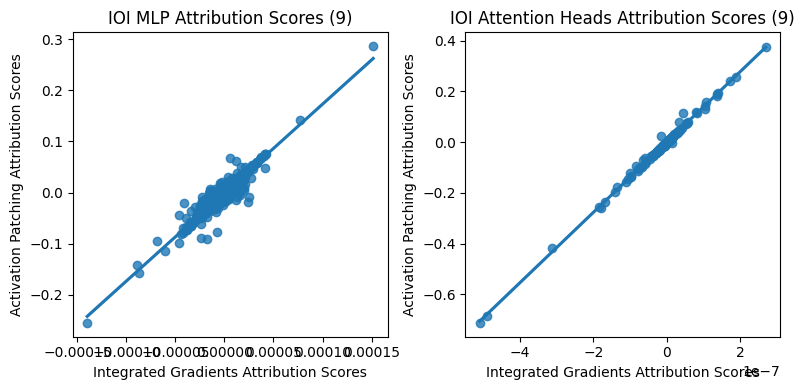

Correlation coefficient for neurons: 0.9687053827582425
Correlation coefficient for attention heads: 0.9978241406180226
Average absolute correlation between IG and AP neurons for IOI: (0.7818885659407933, 0.5572793196006637)
Average absolute correlation between IG and AP attention heads for IOI: (0.8163633394644311, 0.5707158276465426)


In [5]:
plot_correlation_comparison(ioi_ig_mlp[:10], ioi_ap_mlp[:10], ioi_ig_attn[:10], ioi_ap_attn[:10], Task.IOI)

print(f"Average absolute correlation between IG and AP neurons for IOI: {average_correlation(ioi_ig_mlp, ioi_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for IOI: {average_correlation(ioi_ig_attn, ioi_ap_attn)}")

In [28]:
ioi_ig_zero_mlp = torch.load("results/aligned/ioi/ig_zero_mlp.pt")
ioi_ig_zero_attn = torch.load("results/aligned/ioi/ig_zero_attn.pt")

print(f"Average absolute correlation between IG zero and AP neurons for IOI: {average_correlation(ioi_ig_zero_mlp, ioi_ap_mlp)}")
print(f"Average absolute correlation between IG zero and AP attention heads for IOI: {average_correlation(ioi_ig_zero_attn, ioi_ap_attn)}")

Average absolute correlation between IG zero and AP neurons for IOI: (np.float64(-0.028726250216542473), np.float64(0.07142099822721198))
Average absolute correlation between IG zero and AP attention heads for IOI: (np.float64(-0.05580745759367625), np.float64(0.1703066009796817))


## Greater-Than

### Experiment

In [31]:
greater_than_dataset = TaskDataset(Task.GREATER_THAN)
greater_than_dataloader = greater_than_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(greater_than_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = greater_than_prob_diff_metric(model, clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = greater_than_prob_diff_metric(model, corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([ 0.8670,  0.8998,  0.9045,  0.8931,  0.8261,  0.8083,  0.9399,  0.8767,
         0.7247,  0.9015,  0.8210,  0.8544,  0.8492,  0.8596,  0.9377,  0.5882,
         0.8244,  0.8729,  0.9530,  0.8655,  0.9432,  0.9268,  0.8044,  0.8718,
         0.6772,  0.8514,  0.8844,  0.8216,  0.8870,  0.7221,  0.9517,  0.8526,
         0.8055,  0.8832,  0.7858,  0.4179,  0.9520,  0.8633,  0.8283,  0.9166,
         0.9020,  0.7755,  0.6411,  0.8366,  0.8993,  0.9411,  0.9138,  0.7848,
         0.8788,  0.8683,  0.4046,  0.8780,  0.9315,  0.8202,  0.8017,  0.8528,
         0.8538,  0.8295,  0.8560,  0.8585,  0.8935,  0.9062,  0.8381,  0.9049,
         0.0631,  0.9225, -0.1883,  0.9213,  0.8439,  0.8605,  0.3895,  0.9208,
         0.8139,  0.8789,  0.8855,  0.9023,  0.5799,  0.8774,  0.8771,  0.9171,
         0.8438, -0.0192,  0.8881,  0.9197,  0.8702,  0.6880,  0.8587,  0.9462,
         0.8470,  0.6209,  0.7185,  0.7852,  0.8294,  0.9640,  0.8169,  0.9211,
         0.9457,

In [10]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

metric_fn = lambda x, labels: greater_than_prob_diff_metric(model, x, labels)
greater_than_ig_zero_mlp, greater_than_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, clean_cache, metric_fn, labels)

torch.save(greater_than_ig_zero_mlp, "results/aligned/greater_than/ig_zero_mlp.pt")
torch.save(greater_than_ig_zero_attn, "results/aligned/greater_than/ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-1.1932e-01, -2.0893e-01,  8.7916e-01, -4.3654e-01, -4.4516e-01,
        -7.5447e-01, -6.3479e-01,  1.1600e+00,  6.4487e-01,  8.3477e-02,
        -8.3873e-01, -9.2300e-01, -4.0502e-02,  3.5753e-01, -5.9558e-01,
         1.1738e+00,  1.5813e+00, -2.4454e-01, -1.9669e-01, -9.3589e-01,
        -1.0107e-01,  1.8185e+00,  7.9356e-01,  9.5582e-01,  1.0944e-01,
         1.6930e+00,  5.0797e-01, -9.4931e-01, -6.6683e-01,  3.2335e-01,
         8.3847e-01, -3.5150e-01,  1.9189e+00,  1.5089e-01, -2.5831e-01,
        -3.4092e-01,  6.1048e-02, -5.4338e-02, -3.8299e-01, -9.2438e-02,
        -6.3450e-01, -5.3435e-01, -7.6904e-01, -1.7285e-01, -3.7544e-01,
         4.0687e-02,  8.9311e-01,  1.4636e+00, -4.4493e-01, -7.1884e-02,
        -5.5947e-01, -1.4699e-01, -3.2845e-01, -7.9590e-01, -1.7282e-03,
         1.4994e-01,  6.6030e-01, -8.9125e-01,  4.3312e-02, -7.1820e-01,
        -2.6426e-01, -3.2303e-01, -1.5905e-01,  1.9628e+00, -2.075

In [33]:
greater_than_ig_mlp, greater_than_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, metric_fn, labels)

torch.save(greater_than_ig_mlp, "results/aligned/greater_than/ig_mlp.pt")
torch.save(greater_than_ig_attn, "results/aligned/greater_than/ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-7.0781e-08,  6.5565e-07, -7.4506e-09, -1.0207e-06,  1.2293e-06,
         1.0431e-07, -2.7567e-07, -1.0729e-06,  7.1526e-07,  8.5682e-07,
         2.4997e-06,  1.0058e-07, -6.7987e-07, -9.1642e-07, -5.1782e-07,
         3.3081e-06, -2.0117e-07, -6.7800e-07,  9.1270e-08,  6.2585e-07,
         4.3958e-07, -7.0781e-08, -9.5367e-07,  2.7753e-07, -1.6987e-06,
         0.0000e+00, -2.3805e-06,  5.8115e-07,  4.8429e-08, -8.9407e-07,
        -7.4506e-09,  1.4380e-06,  1.9632e-06, -1.1548e-07,  1.4454e-06,
         5.9903e-06,  7.4506e-09, -2.0489e-06,  3.4273e-07,  7.5623e-07,
        -4.4703e-07,  1.4901e-07,  2.1011e-06,  9.9838e-07, -1.7434e-06,
        -2.7008e-08,  1.7881e-07, -3.2783e-07,  1.2666e-07,  2.5108e-06,
        -3.6657e-06,  8.8289e-07, -1.1772e-06,  1.0431e-06, -9.5367e-07,
         1.8701e-06, -2.1458e-06, -8.9407e-08,  1.2666e-06,  1.1325e-06,
         7.7486e-07, -5.6624e-07, -2.0936e-06, -9.7603e-07,  5.245

In [34]:
greater_than_ap_mlp, greater_than_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, metric_fn, labels)

torch.save(greater_than_ap_mlp, "results/aligned/greater_than/ap_mlp.pt")
torch.save(greater_than_ap_attn, "results/aligned/greater_than/ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

### Analysis

In [35]:
greater_than_ig_mlp = torch.load("results/aligned/greater_than/ig_mlp.pt")
greater_than_ig_attn = torch.load("results/aligned/greater_than/ig_attn.pt")
greater_than_ap_mlp = torch.load("results/aligned/greater_than/ap_mlp.pt")
greater_than_ap_attn = torch.load("results/aligned/greater_than/ap_attn.pt")

In [36]:
print_jaccard_multi(greater_than_ig_mlp, greater_than_ig_attn, greater_than_ap_mlp, greater_than_ap_attn)

Average Jaccard similarity score for MLP: 0.6983146071434021
Average Jaccard similarity score for Attention: 0.8960416913032532
Jaccard similarity std for MLP: 0.12688176333904266
Jaccard similarity std for Attention: 0.24967558681964874


In [37]:
greater_than_ig_zero_mlp = torch.load("results/aligned/greater_than/ig_zero_mlp.pt")
greater_than_ig_zero_attn = torch.load("results/aligned/greater_than/ig_zero_attn.pt")

print("For zero baseline:")
print_jaccard_multi(greater_than_ig_zero_mlp, greater_than_ig_zero_attn, greater_than_ap_mlp, greater_than_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.19233955442905426
Average Jaccard similarity score for Attention: 0.3368658423423767
Jaccard similarity std for MLP: 0.07887403666973114
Jaccard similarity std for Attention: 0.4222550094127655


In [38]:
print(f"Average absolute correlation between IG and AP neurons for Greater-Than: {average_correlation(greater_than_ig_mlp, greater_than_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Greater-Than: {average_correlation(greater_than_ig_attn, greater_than_ap_attn)}")

Average absolute correlation between IG and AP neurons for Greater-Than: (np.float64(0.8926193747015398), np.float64(0.059285392469286935))
Average absolute correlation between IG and AP attention heads for Greater-Than: (np.float64(0.994375310127196), np.float64(0.0035370949661940212))


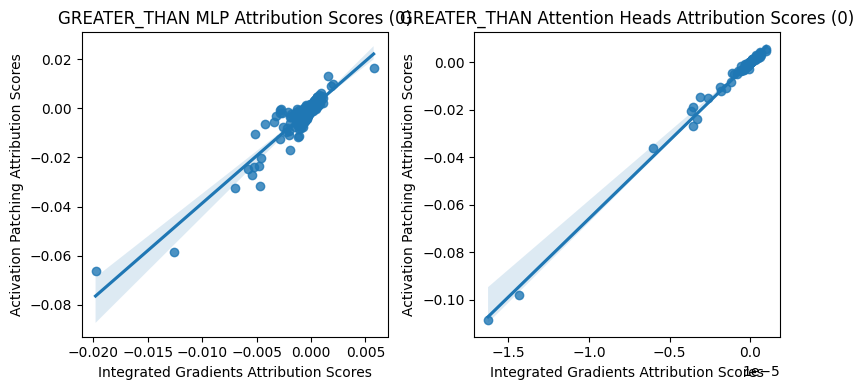

Correlation coefficient for neurons: 0.9221149840382168
Correlation coefficient for attention heads: 0.9965489461834278


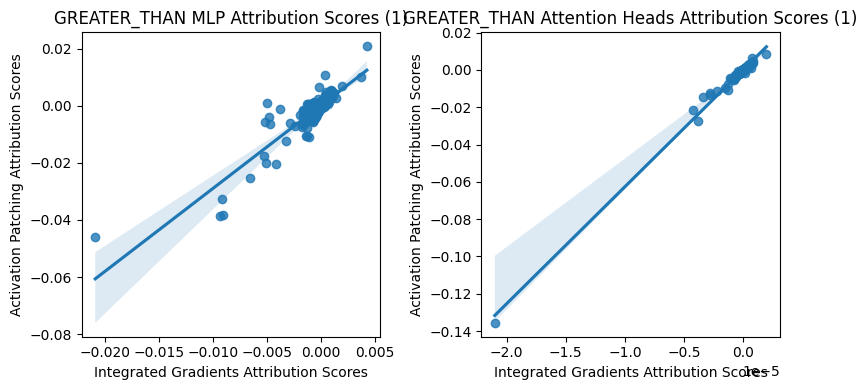

Correlation coefficient for neurons: 0.8871166453075257
Correlation coefficient for attention heads: 0.994403511997816


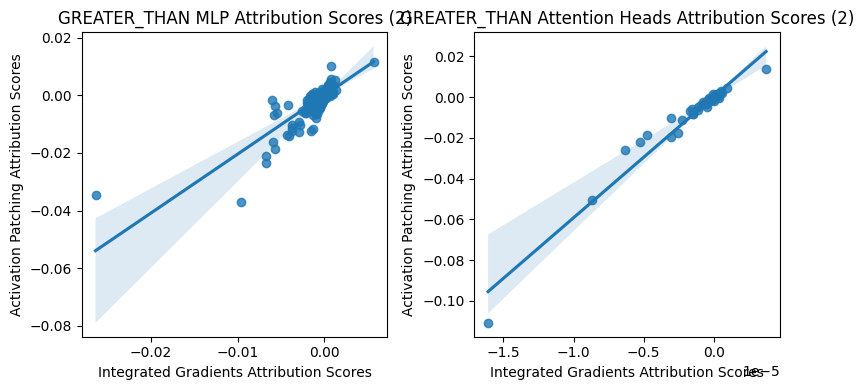

Correlation coefficient for neurons: 0.8278466946896172
Correlation coefficient for attention heads: 0.9771733742727247


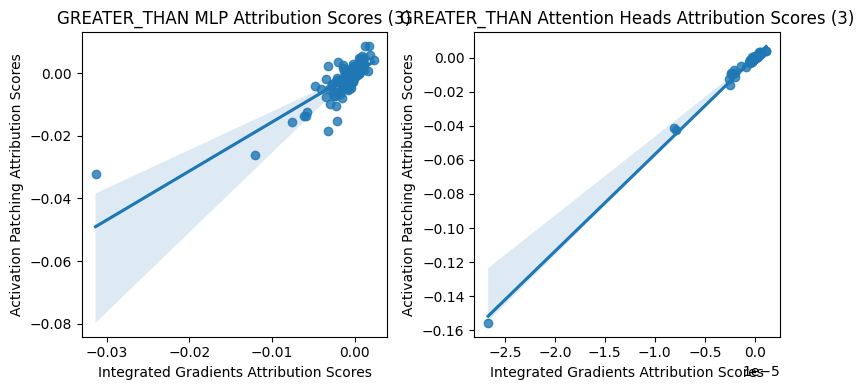

Correlation coefficient for neurons: 0.7898179730112223
Correlation coefficient for attention heads: 0.9973162494837577


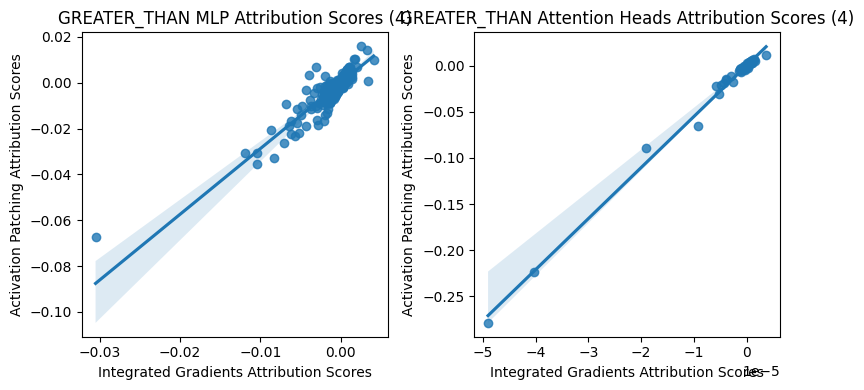

Correlation coefficient for neurons: 0.8947028293174808
Correlation coefficient for attention heads: 0.9962797930654101


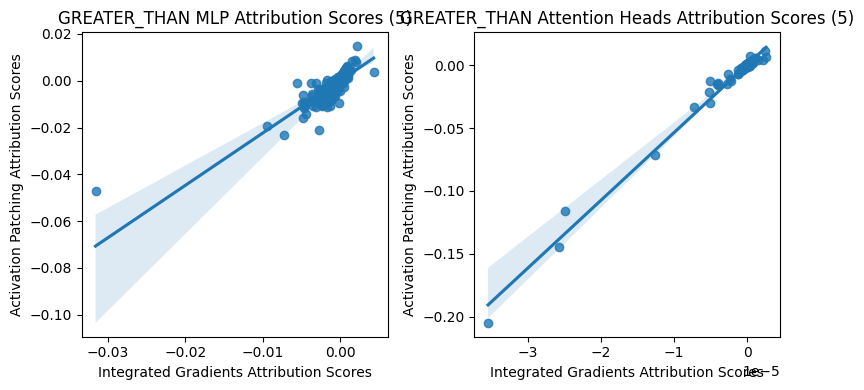

Correlation coefficient for neurons: 0.8296863775069145
Correlation coefficient for attention heads: 0.9922651414908626


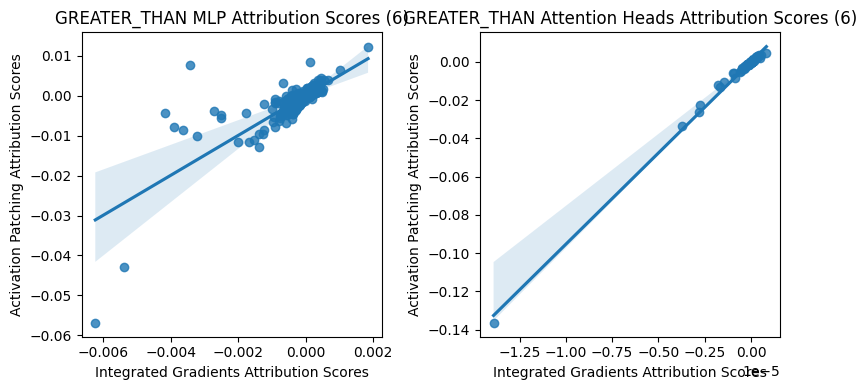

Correlation coefficient for neurons: 0.8026926238090849
Correlation coefficient for attention heads: 0.9968273343630988


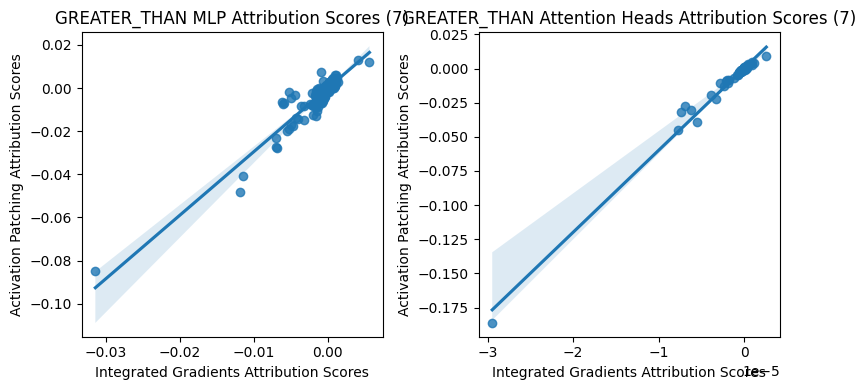

Correlation coefficient for neurons: 0.9285628323975108
Correlation coefficient for attention heads: 0.991371438014334


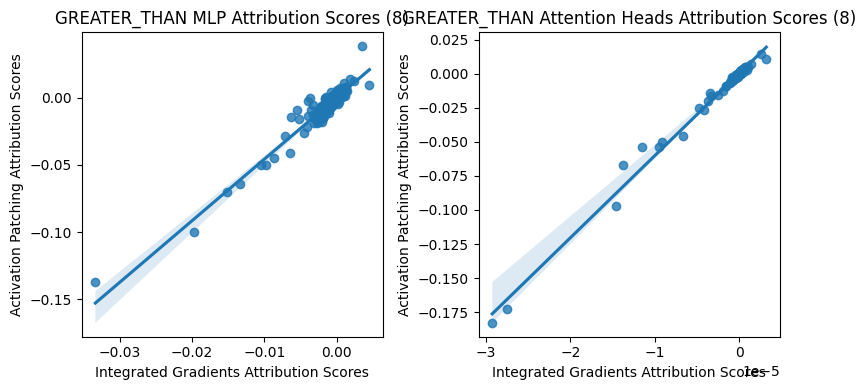

Correlation coefficient for neurons: 0.9588911220507547
Correlation coefficient for attention heads: 0.9946135451585919


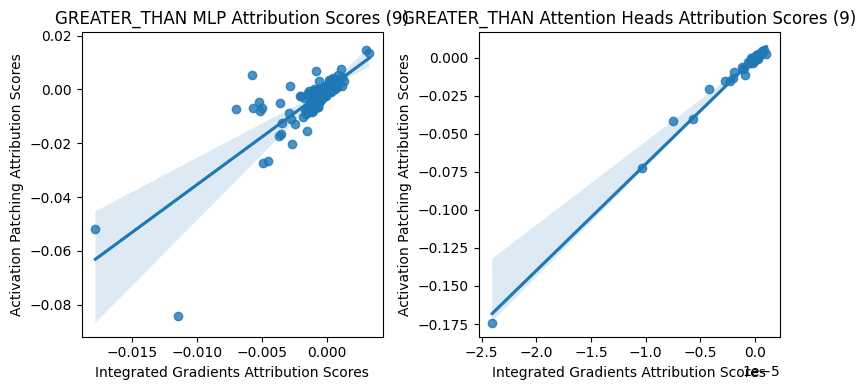

Correlation coefficient for neurons: 0.8240726139902538
Correlation coefficient for attention heads: 0.9953043915296892


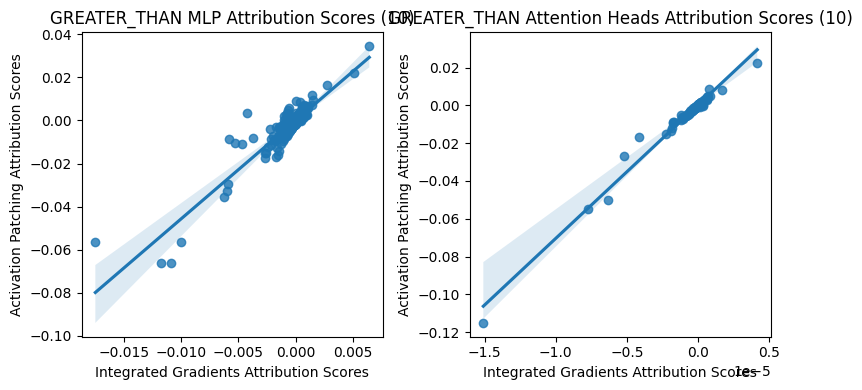

Correlation coefficient for neurons: 0.9168305079508576
Correlation coefficient for attention heads: 0.9874546488908568


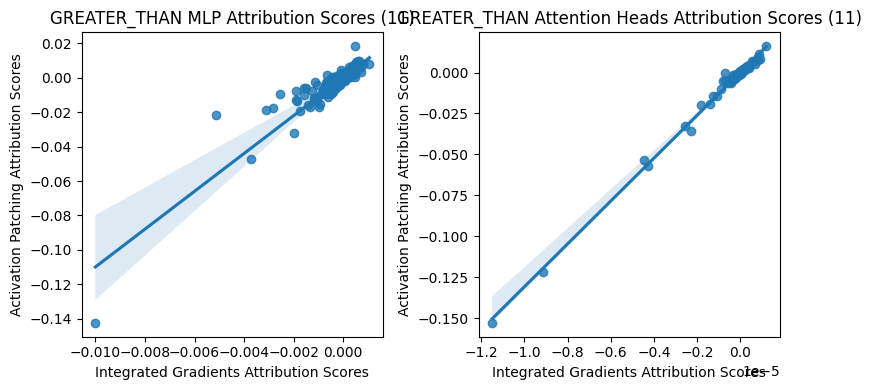

Correlation coefficient for neurons: 0.9186194885160659
Correlation coefficient for attention heads: 0.996700237376432


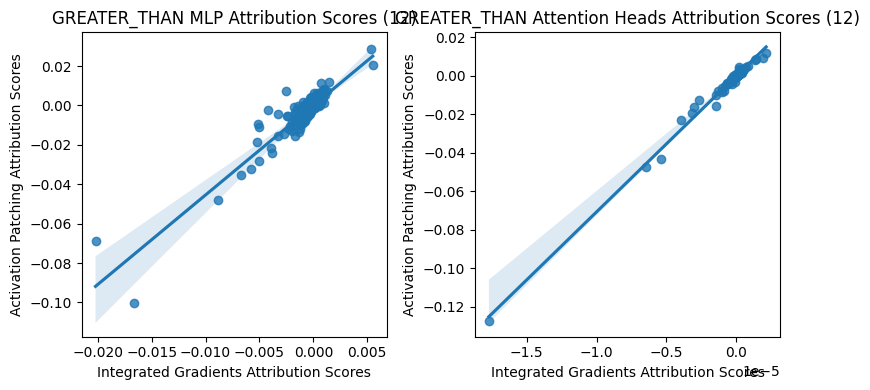

Correlation coefficient for neurons: 0.9215168760363426
Correlation coefficient for attention heads: 0.9945714373820402


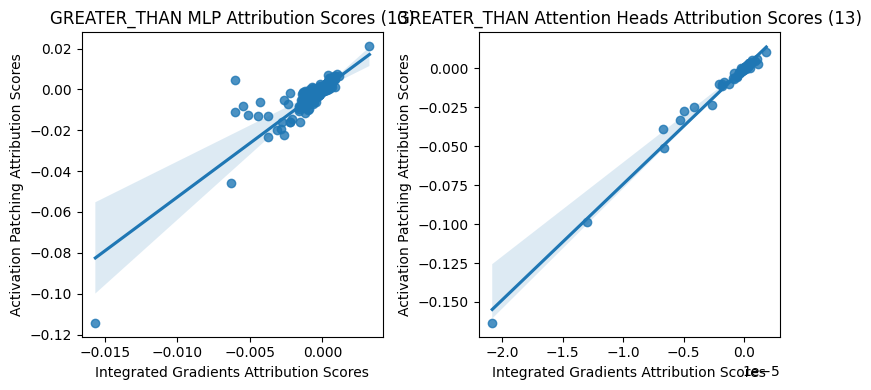

Correlation coefficient for neurons: 0.8805185866163808
Correlation coefficient for attention heads: 0.9937069906259662


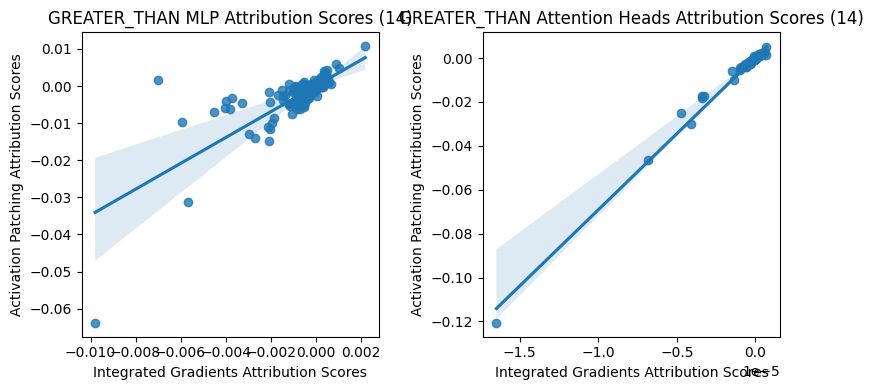

Correlation coefficient for neurons: 0.7966834755683487
Correlation coefficient for attention heads: 0.993051887602043


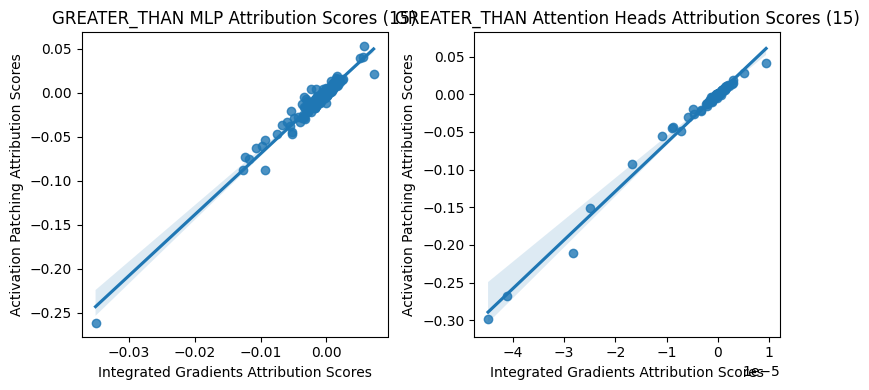

Correlation coefficient for neurons: 0.9756367190515263
Correlation coefficient for attention heads: 0.9944996635222438


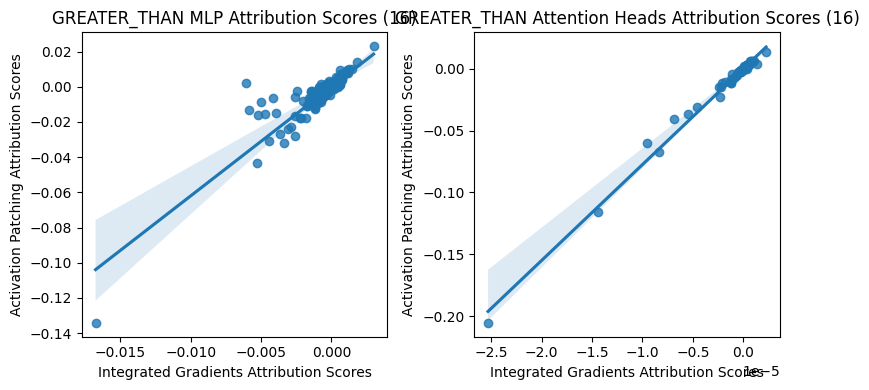

Correlation coefficient for neurons: 0.9018641544007332
Correlation coefficient for attention heads: 0.994554667436726


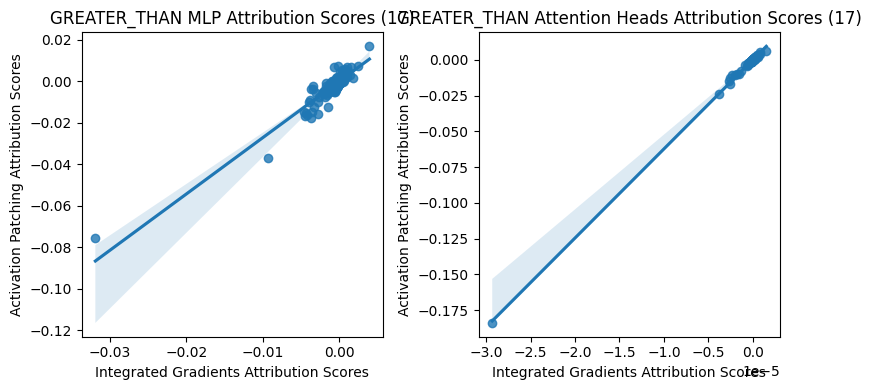

Correlation coefficient for neurons: 0.9213354949880638
Correlation coefficient for attention heads: 0.9990638262311877


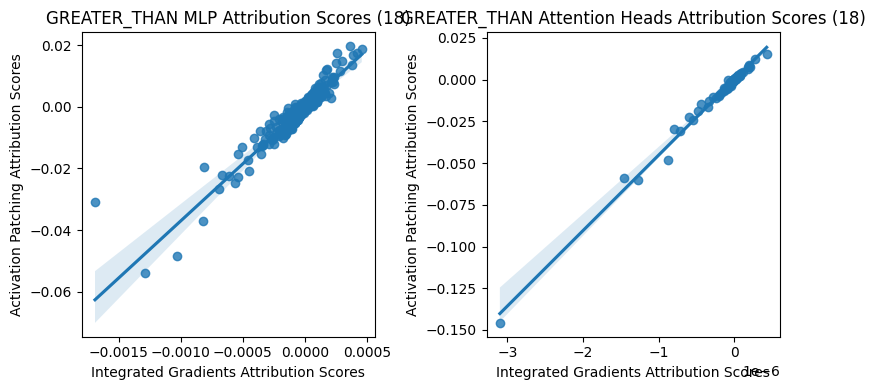

Correlation coefficient for neurons: 0.9404852439834482
Correlation coefficient for attention heads: 0.9952446339359532


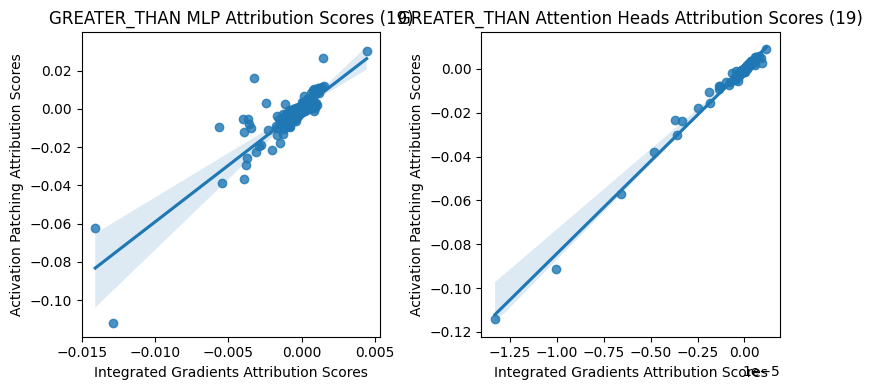

Correlation coefficient for neurons: 0.878927720474297
Correlation coefficient for attention heads: 0.9948705243664312


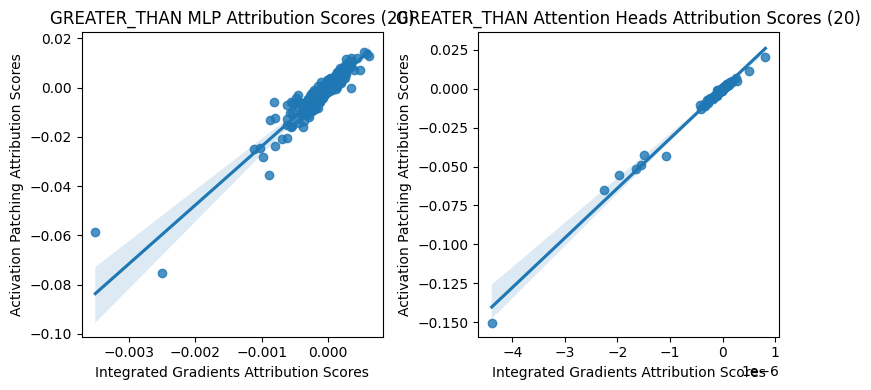

Correlation coefficient for neurons: 0.9346111905124648
Correlation coefficient for attention heads: 0.9945346403270429


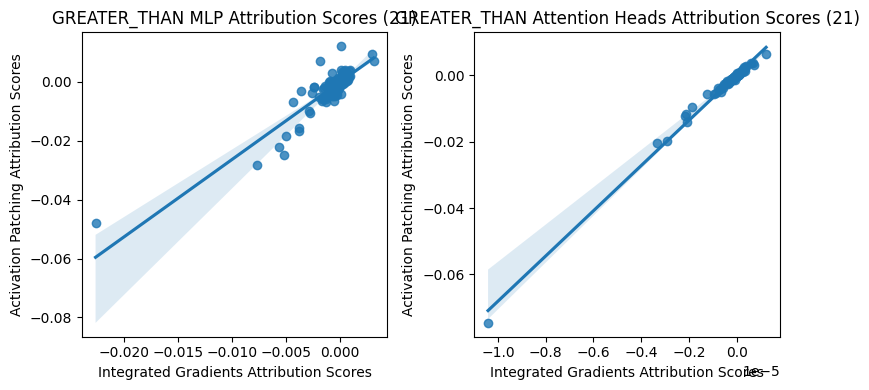

Correlation coefficient for neurons: 0.875447604232861
Correlation coefficient for attention heads: 0.9947870629887018


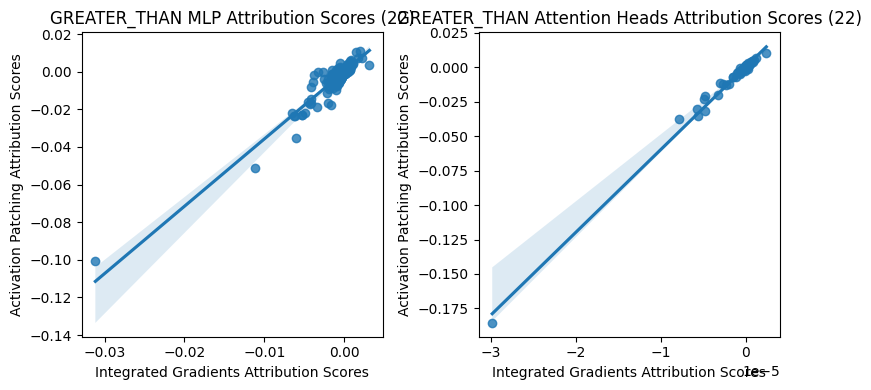

Correlation coefficient for neurons: 0.9379821653658422
Correlation coefficient for attention heads: 0.9949124794700581


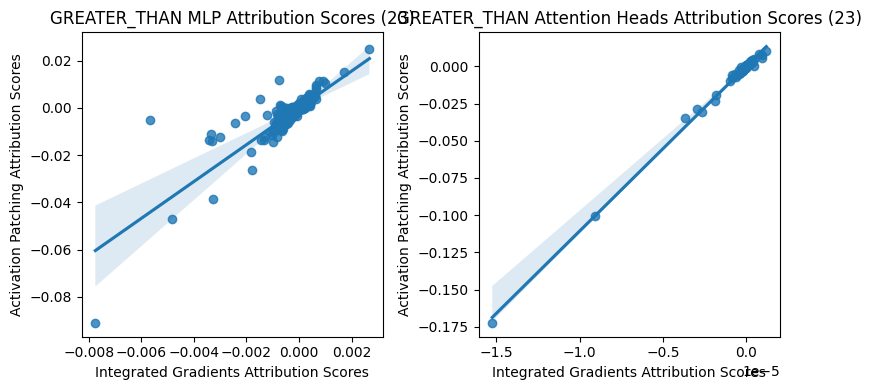

Correlation coefficient for neurons: 0.8596782533907236
Correlation coefficient for attention heads: 0.9978683604058217


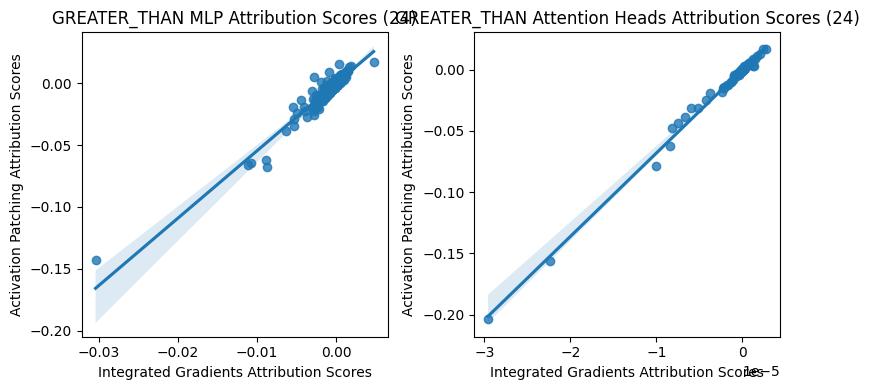

Correlation coefficient for neurons: 0.9571409840969212
Correlation coefficient for attention heads: 0.996303894764451


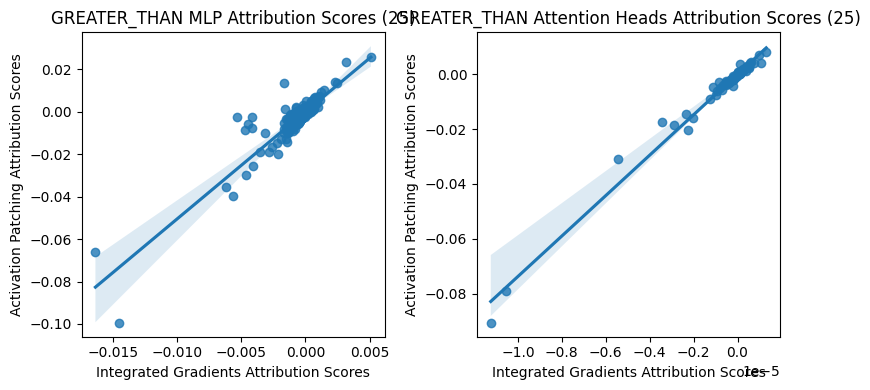

Correlation coefficient for neurons: 0.9078020544652743
Correlation coefficient for attention heads: 0.9903304042450883


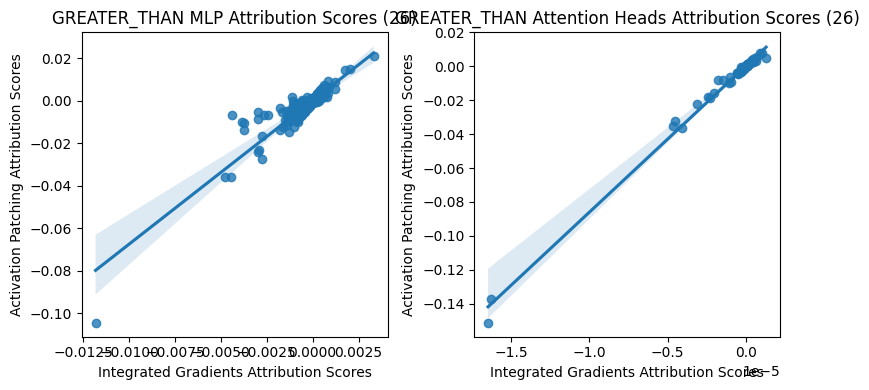

Correlation coefficient for neurons: 0.9189032076489112
Correlation coefficient for attention heads: 0.9961786591069463


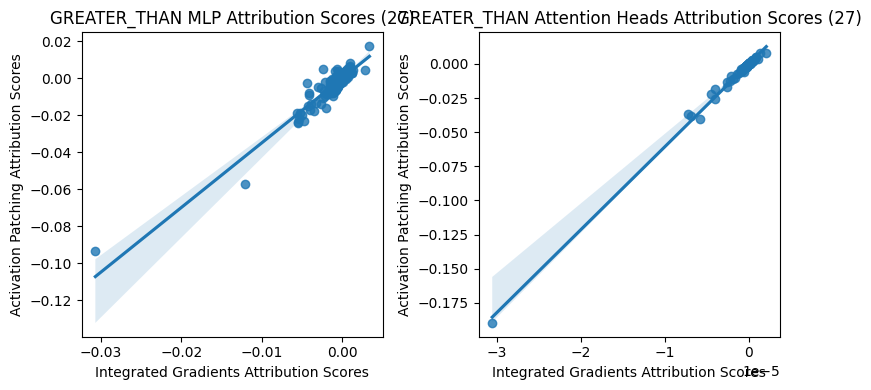

Correlation coefficient for neurons: 0.9369830213335268
Correlation coefficient for attention heads: 0.9969178938258612


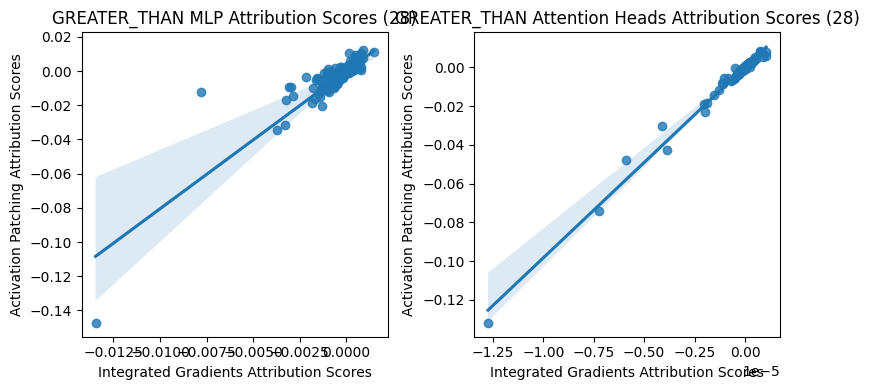

Correlation coefficient for neurons: 0.8891866774992238
Correlation coefficient for attention heads: 0.9928827241914403


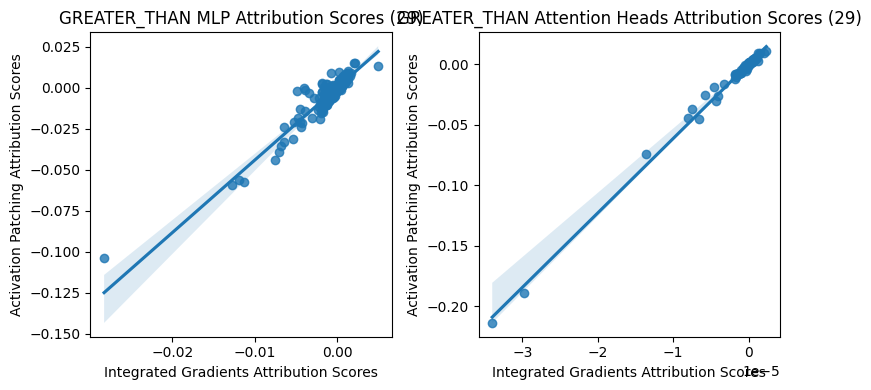

Correlation coefficient for neurons: 0.9369070894738434
Correlation coefficient for attention heads: 0.9966966431528559


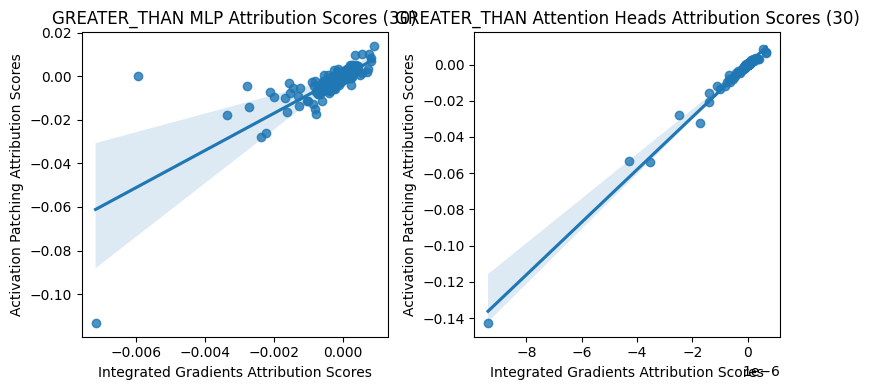

Correlation coefficient for neurons: 0.793897796584836
Correlation coefficient for attention heads: 0.9937524445962681


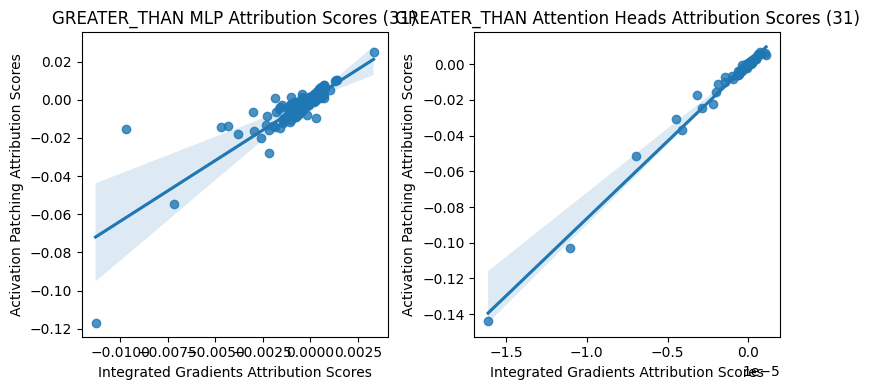

Correlation coefficient for neurons: 0.8658274863334053
Correlation coefficient for attention heads: 0.9936168450938943


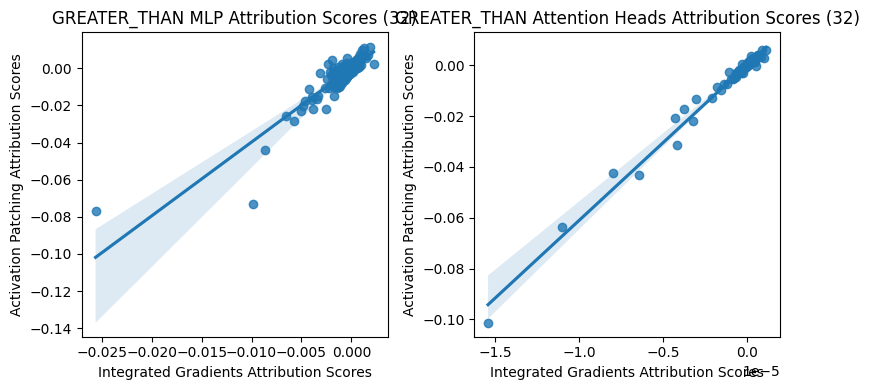

Correlation coefficient for neurons: 0.901290516424552
Correlation coefficient for attention heads: 0.9917942051836335


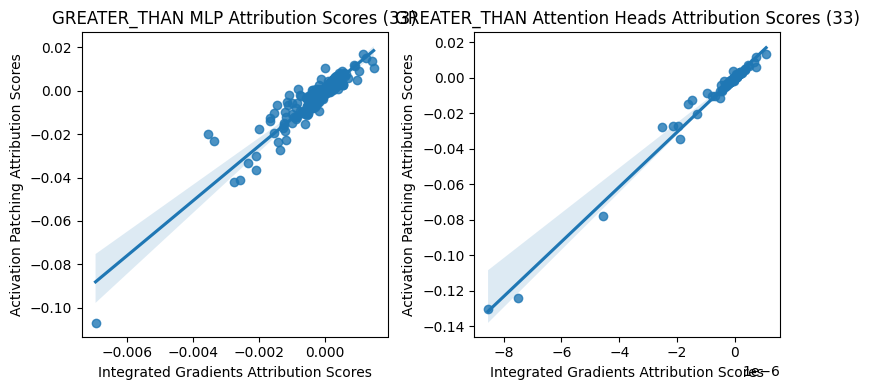

Correlation coefficient for neurons: 0.9281302994542595
Correlation coefficient for attention heads: 0.9918212685612062


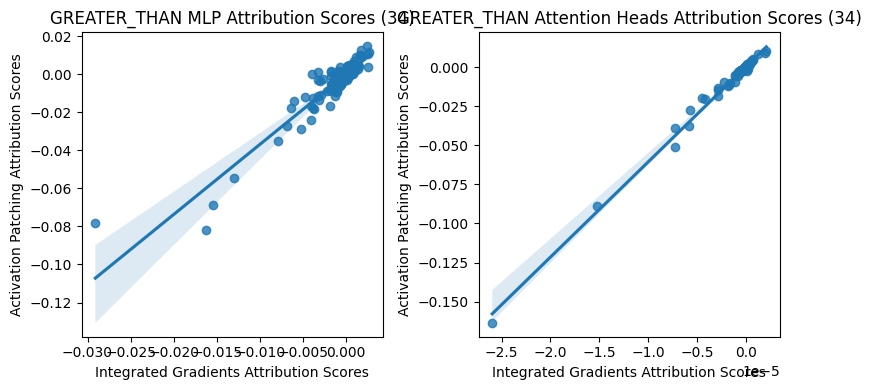

Correlation coefficient for neurons: 0.9261353391484051
Correlation coefficient for attention heads: 0.9958380766436916


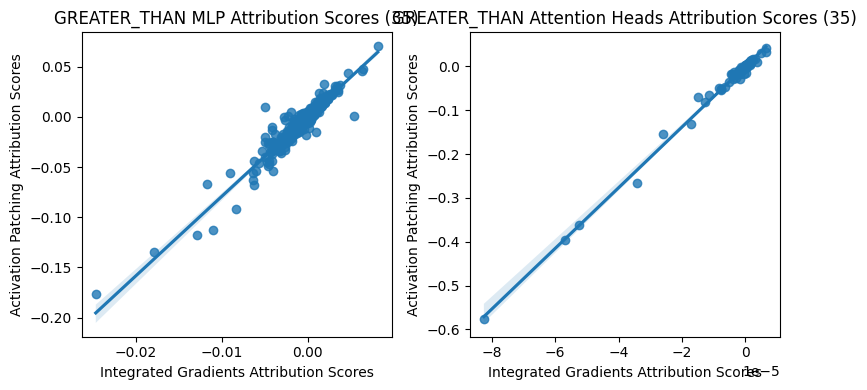

Correlation coefficient for neurons: 0.9605526946373691
Correlation coefficient for attention heads: 0.9963552814866155


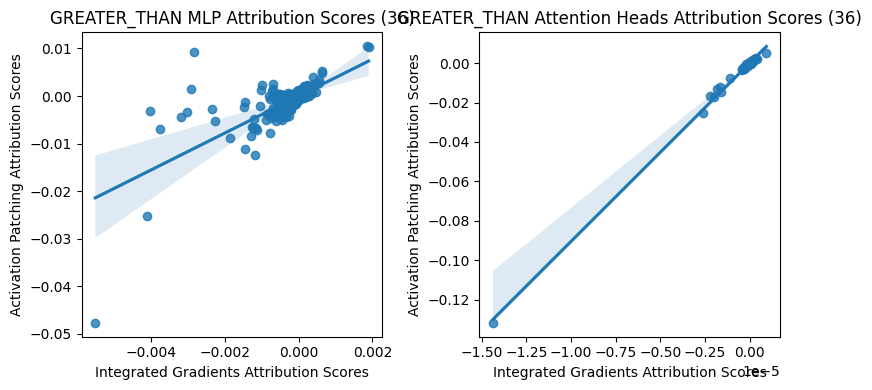

Correlation coefficient for neurons: 0.7284375512722818
Correlation coefficient for attention heads: 0.9981489548406078


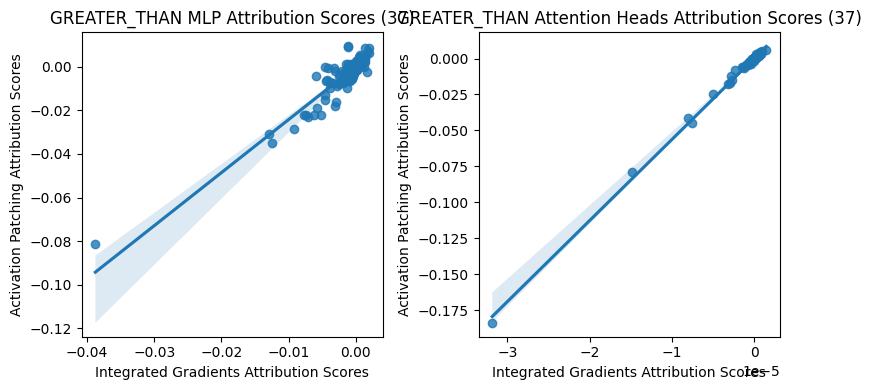

Correlation coefficient for neurons: 0.9088976362732096
Correlation coefficient for attention heads: 0.9982591720751259


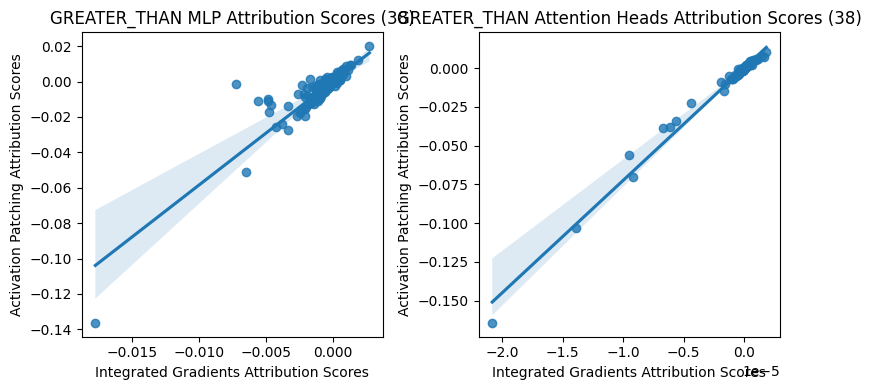

Correlation coefficient for neurons: 0.9058207280144371
Correlation coefficient for attention heads: 0.9922214389512908


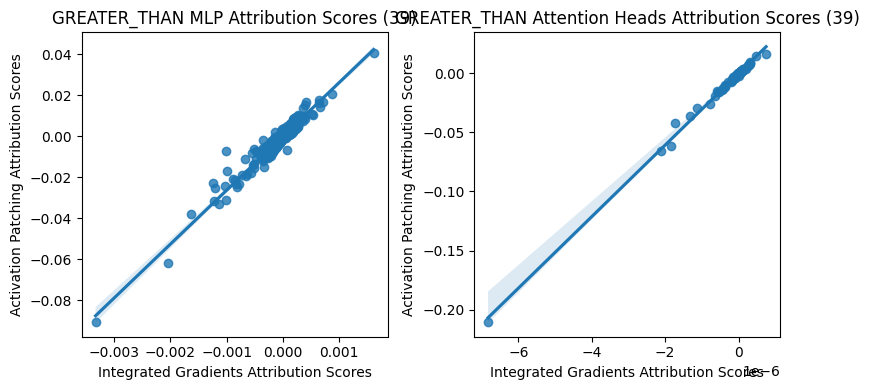

Correlation coefficient for neurons: 0.962652156822383
Correlation coefficient for attention heads: 0.9975762124310146


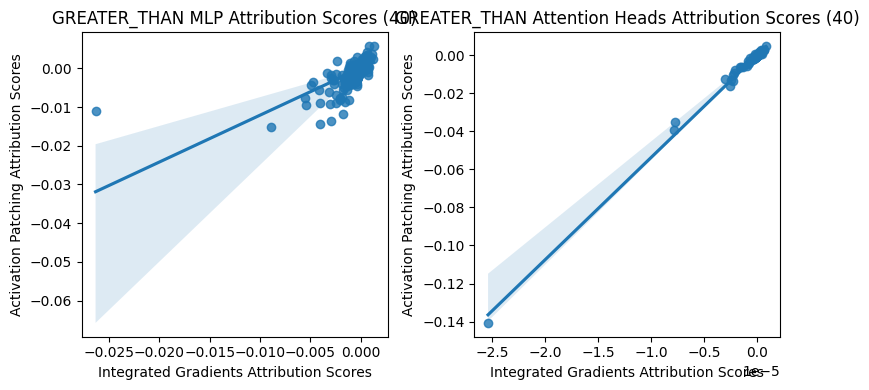

Correlation coefficient for neurons: 0.6446363762288788
Correlation coefficient for attention heads: 0.9967954266496823


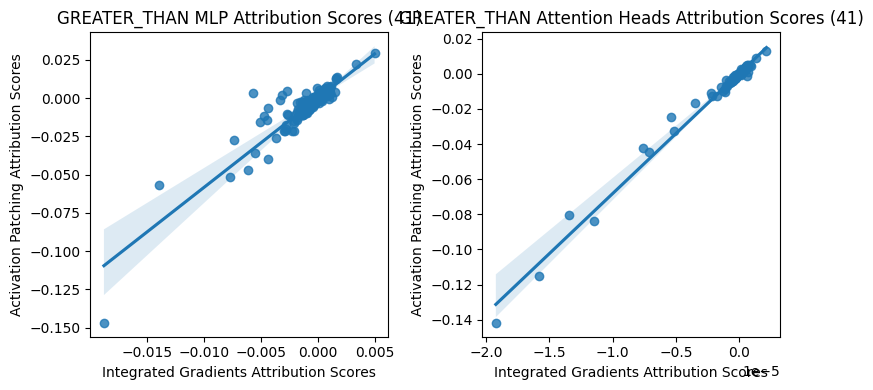

Correlation coefficient for neurons: 0.916038465195635
Correlation coefficient for attention heads: 0.9926243160992312


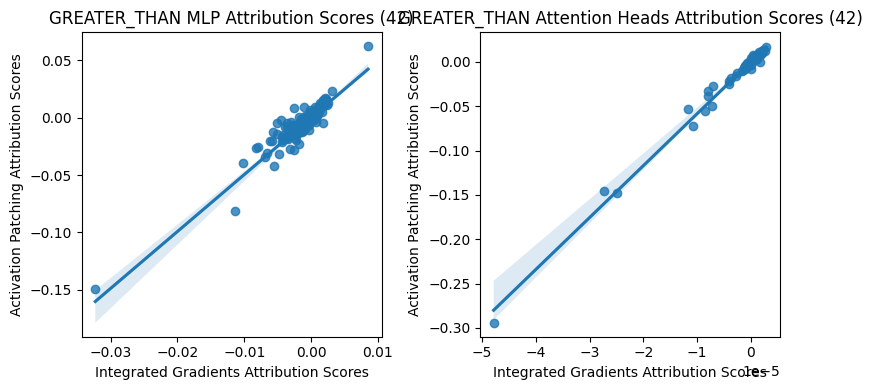

Correlation coefficient for neurons: 0.9309526622342703
Correlation coefficient for attention heads: 0.9940566160181984


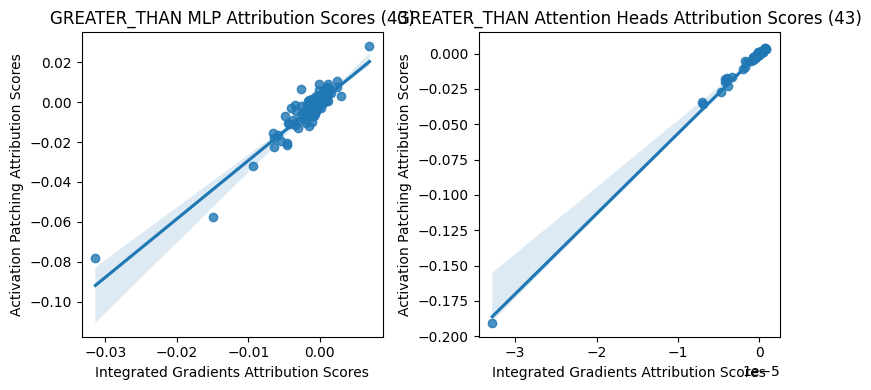

Correlation coefficient for neurons: 0.9194191331612113
Correlation coefficient for attention heads: 0.997386228324339


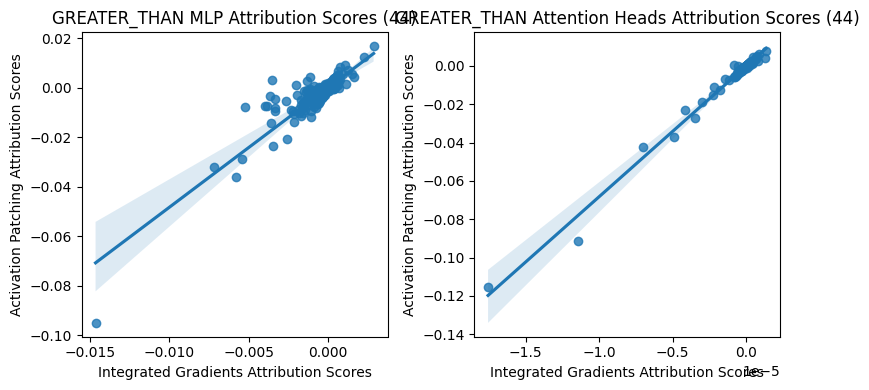

Correlation coefficient for neurons: 0.8937610124886579
Correlation coefficient for attention heads: 0.9921402032873399


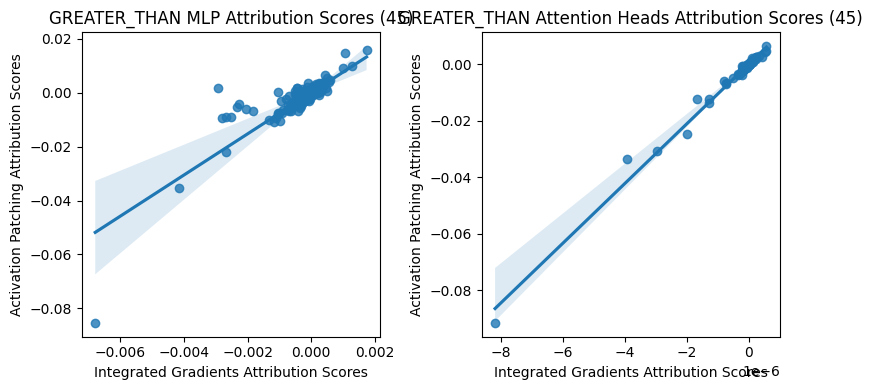

Correlation coefficient for neurons: 0.8620382094632242
Correlation coefficient for attention heads: 0.9932450427297231


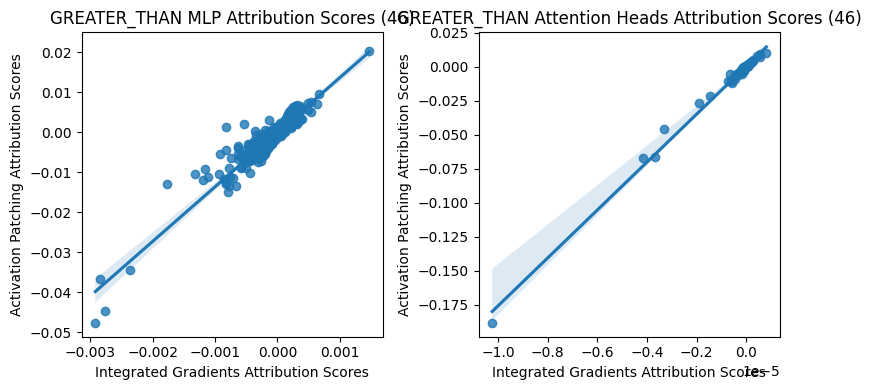

Correlation coefficient for neurons: 0.937460990146444
Correlation coefficient for attention heads: 0.9957417705018725


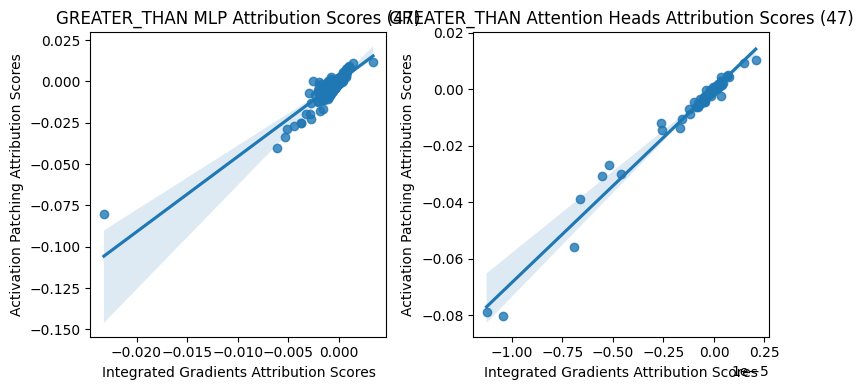

Correlation coefficient for neurons: 0.9106584404604097
Correlation coefficient for attention heads: 0.9886428432366942


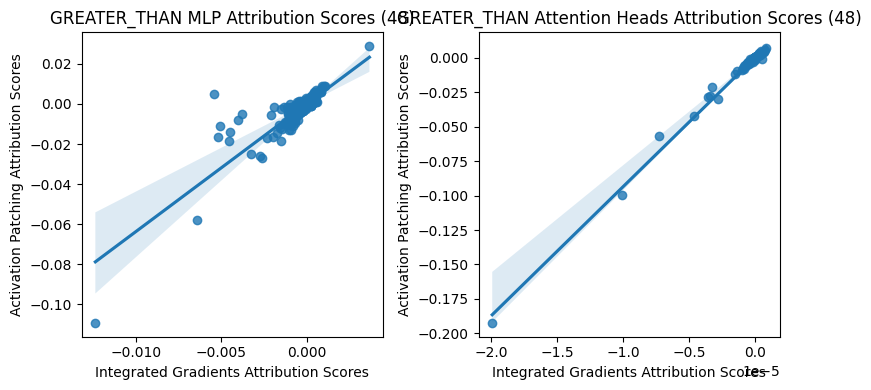

Correlation coefficient for neurons: 0.8725265238351634
Correlation coefficient for attention heads: 0.9957716160397466


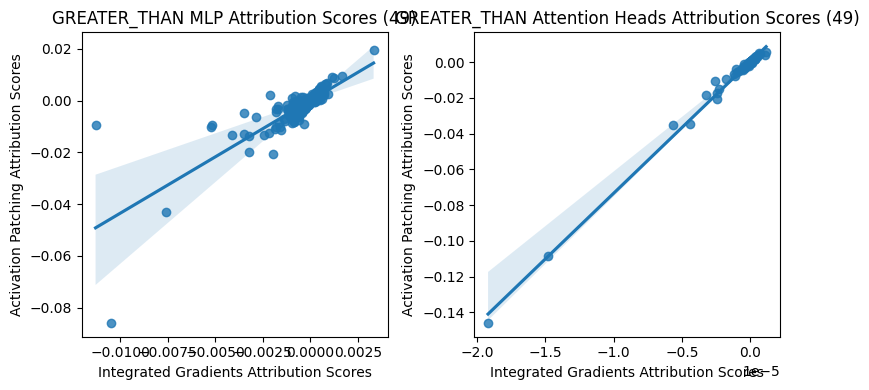

Correlation coefficient for neurons: 0.8196034168946155
Correlation coefficient for attention heads: 0.9962879283446772


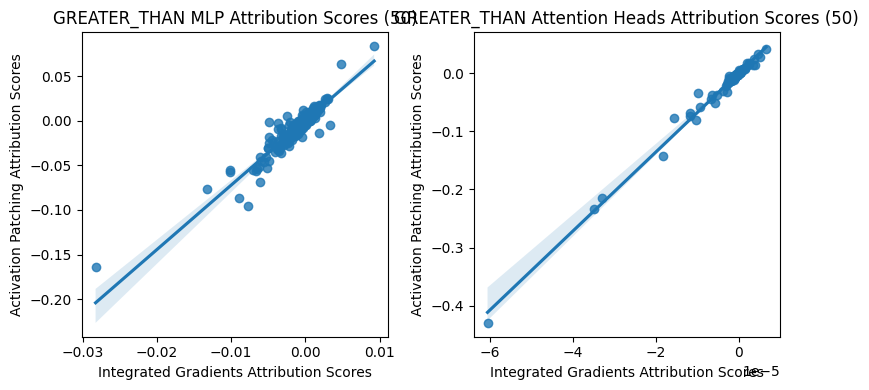

Correlation coefficient for neurons: 0.9456698235424867
Correlation coefficient for attention heads: 0.9939327371846138


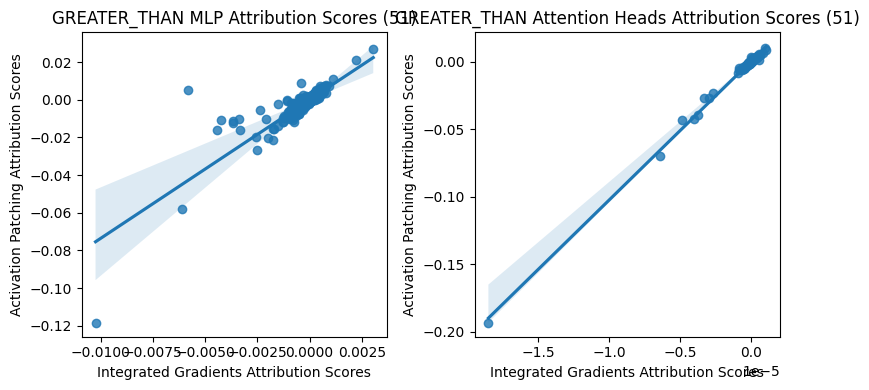

Correlation coefficient for neurons: 0.861317518350531
Correlation coefficient for attention heads: 0.9973665444697356


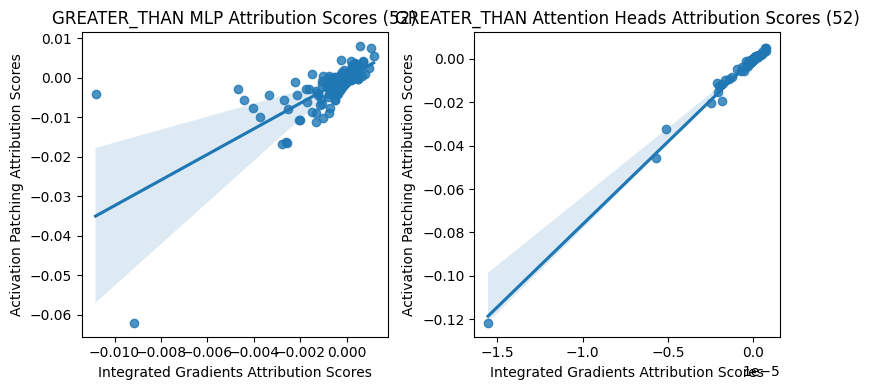

Correlation coefficient for neurons: 0.7335475890469683
Correlation coefficient for attention heads: 0.9952224481795241


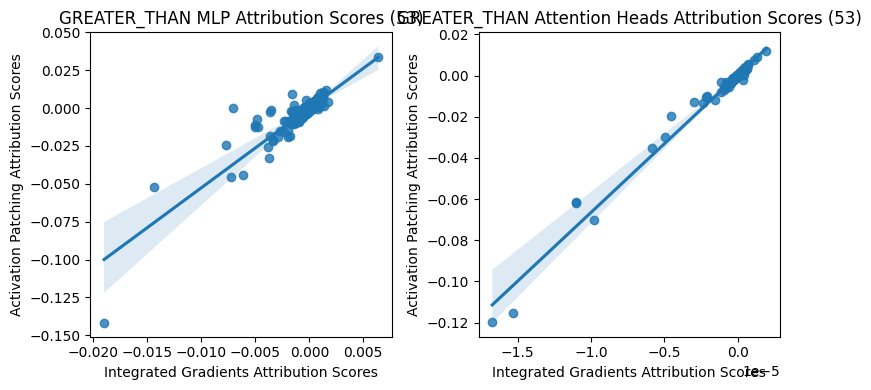

Correlation coefficient for neurons: 0.9004672930371959
Correlation coefficient for attention heads: 0.9902711637000078


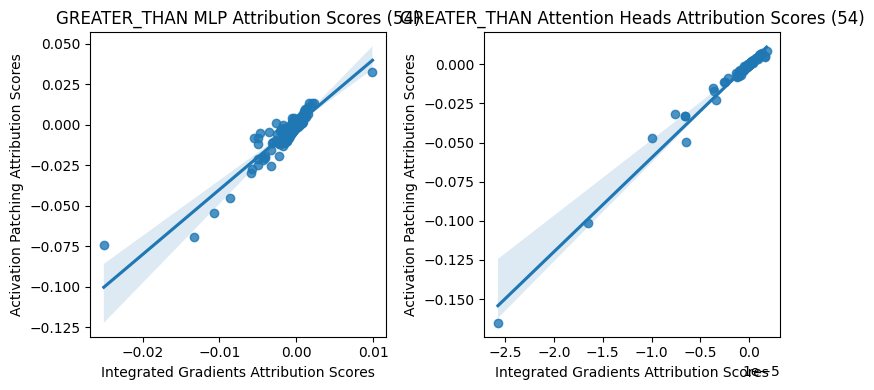

Correlation coefficient for neurons: 0.9286651804364087
Correlation coefficient for attention heads: 0.9902232081751817


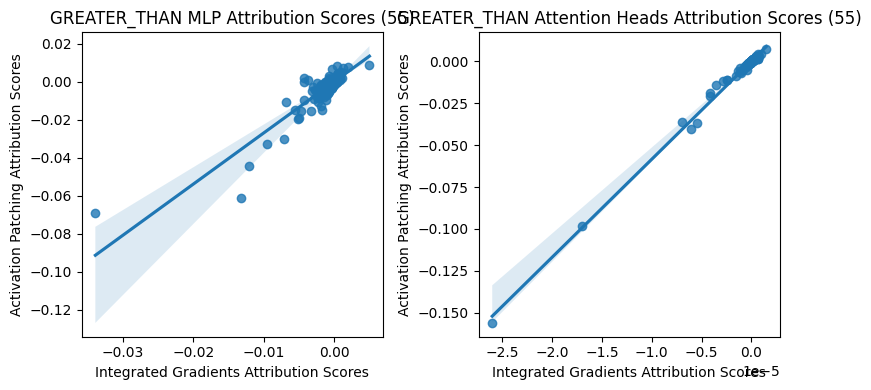

Correlation coefficient for neurons: 0.8922227493762965
Correlation coefficient for attention heads: 0.9964607692175065


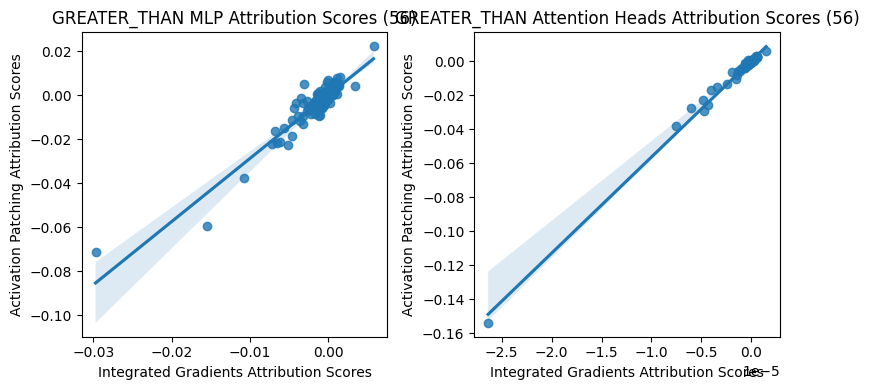

Correlation coefficient for neurons: 0.9229127478377843
Correlation coefficient for attention heads: 0.9958815891242374


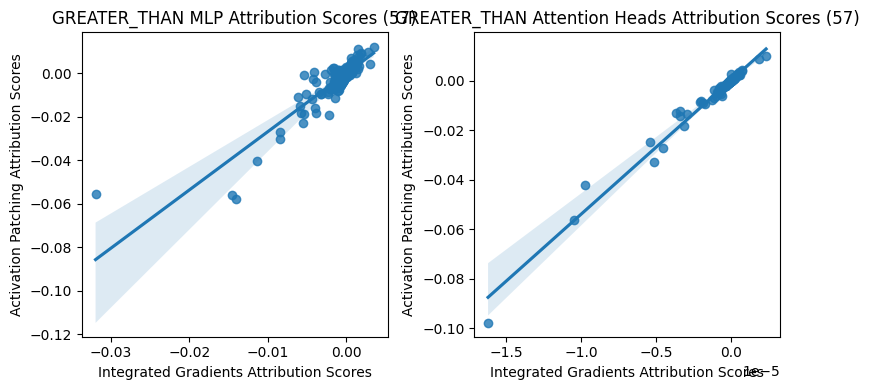

Correlation coefficient for neurons: 0.8818649699017436
Correlation coefficient for attention heads: 0.9875315817855664


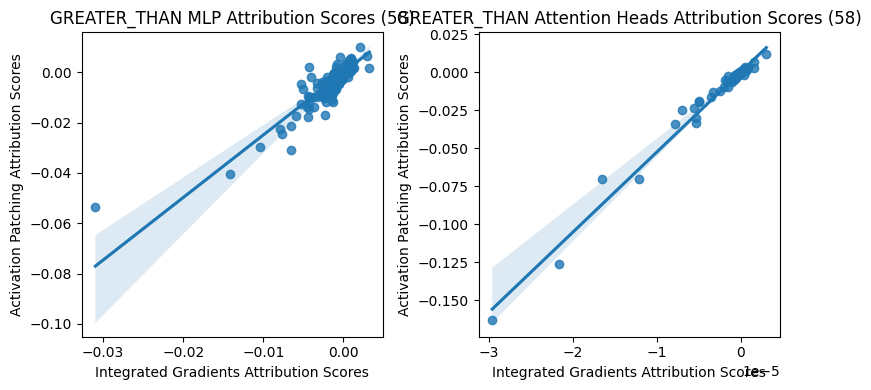

Correlation coefficient for neurons: 0.8860569629954973
Correlation coefficient for attention heads: 0.9904081513103242


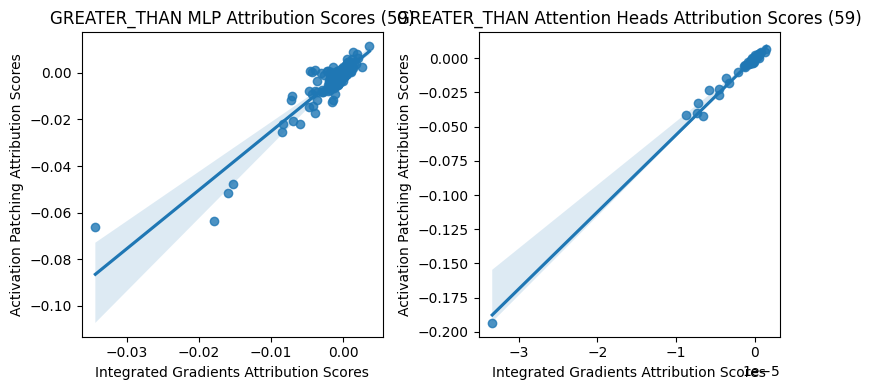

Correlation coefficient for neurons: 0.9135045897775886
Correlation coefficient for attention heads: 0.9958423587016684


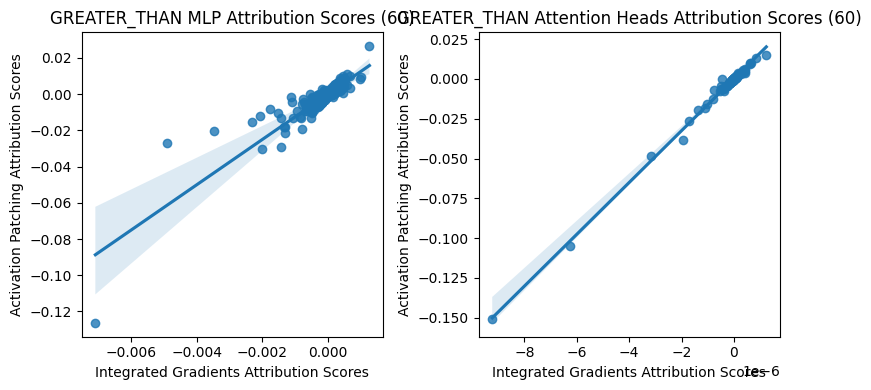

Correlation coefficient for neurons: 0.8949180071391357
Correlation coefficient for attention heads: 0.997059010736661


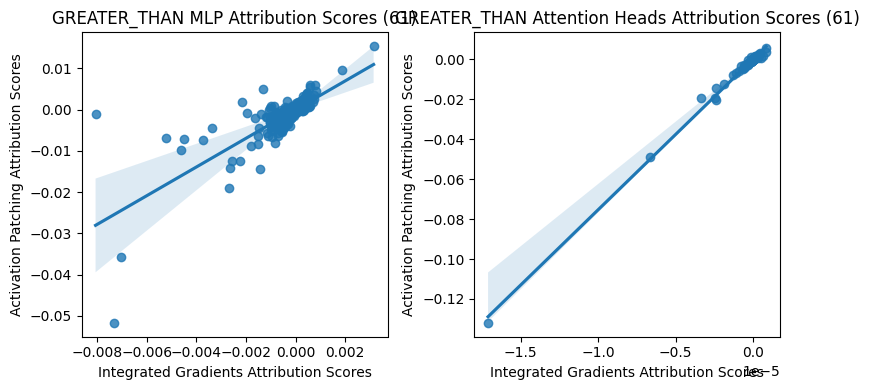

Correlation coefficient for neurons: 0.7783403230135204
Correlation coefficient for attention heads: 0.9970272194110738


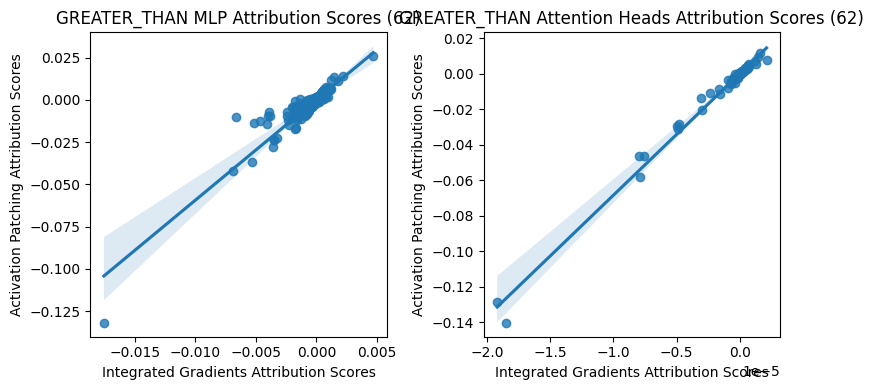

Correlation coefficient for neurons: 0.9297646356376034
Correlation coefficient for attention heads: 0.9940588853174958


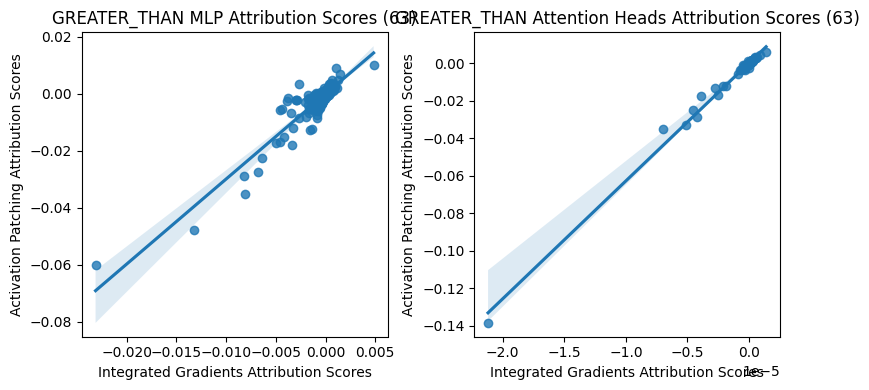

Correlation coefficient for neurons: 0.9179774049098365
Correlation coefficient for attention heads: 0.9951048543245433


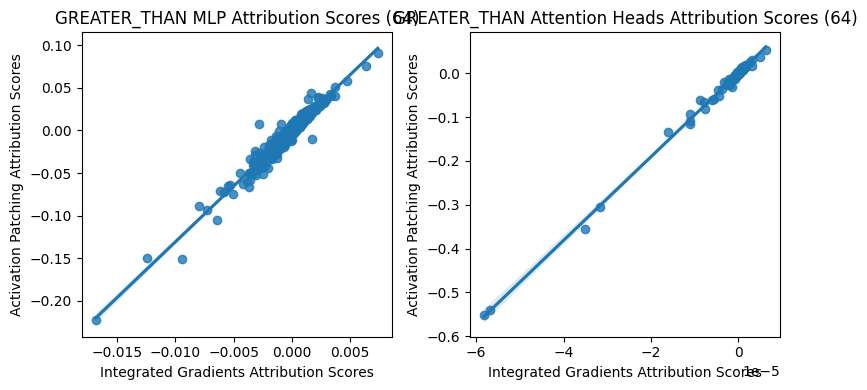

Correlation coefficient for neurons: 0.9778555886890101
Correlation coefficient for attention heads: 0.9981813245327293


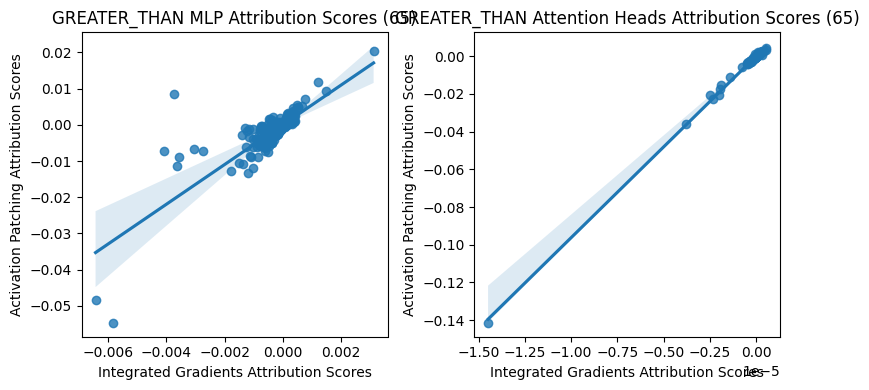

Correlation coefficient for neurons: 0.829591704589234
Correlation coefficient for attention heads: 0.9986064588317283


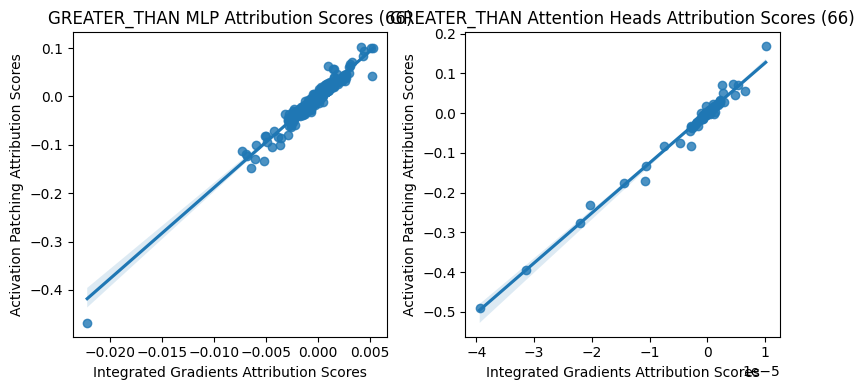

Correlation coefficient for neurons: 0.9767359525225217
Correlation coefficient for attention heads: 0.9916372590544458


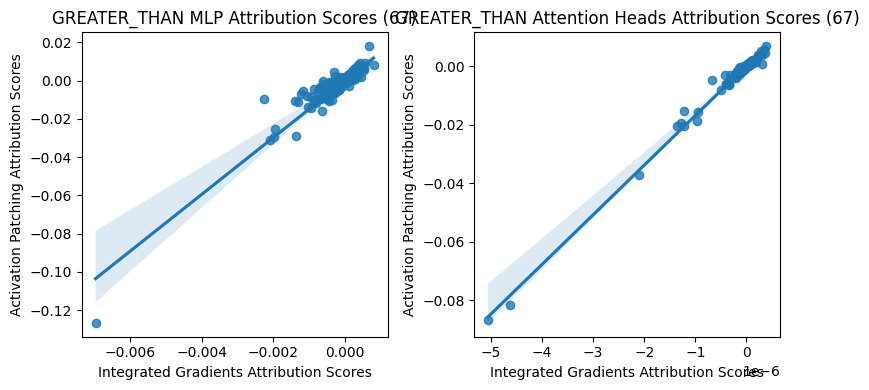

Correlation coefficient for neurons: 0.9369800031609171
Correlation coefficient for attention heads: 0.9948860906957867


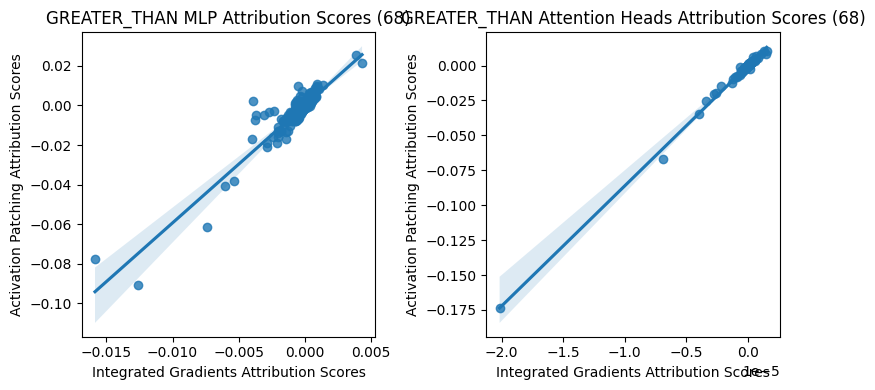

Correlation coefficient for neurons: 0.9272485006473755
Correlation coefficient for attention heads: 0.9971726132394955


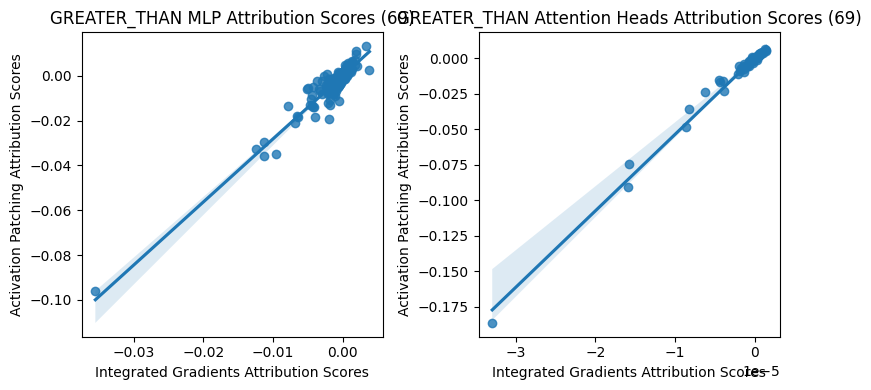

Correlation coefficient for neurons: 0.9353331224968137
Correlation coefficient for attention heads: 0.9939670381046563


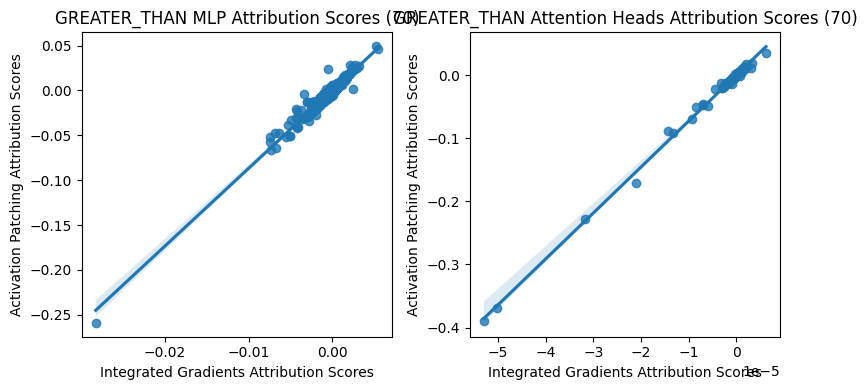

Correlation coefficient for neurons: 0.9797868211581204
Correlation coefficient for attention heads: 0.9979979045554003


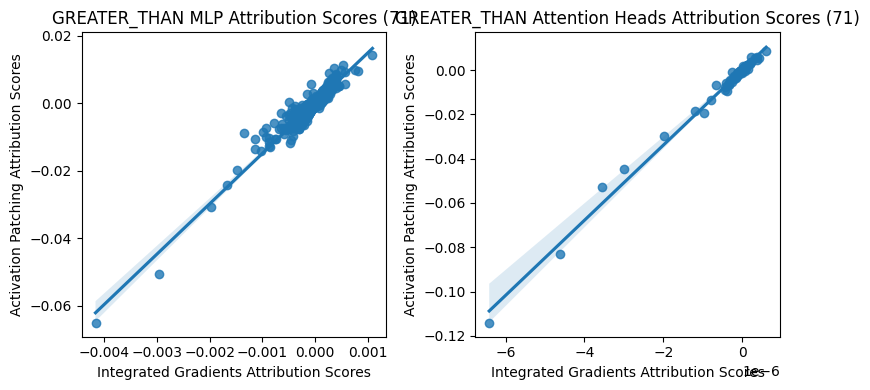

Correlation coefficient for neurons: 0.9529728945758235
Correlation coefficient for attention heads: 0.995405487504454


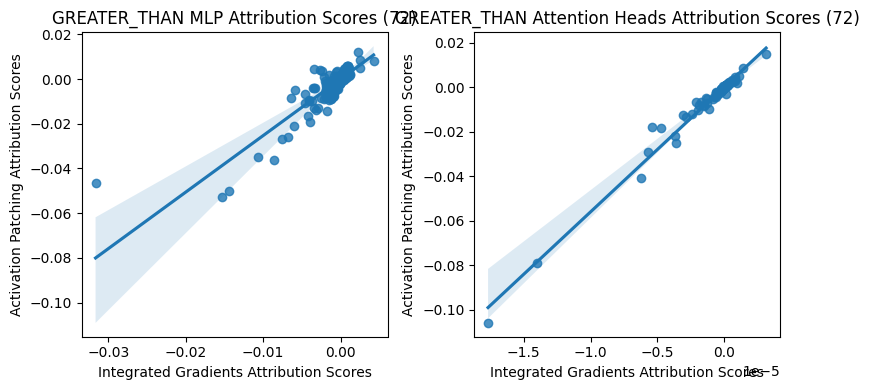

Correlation coefficient for neurons: 0.8614791867873323
Correlation coefficient for attention heads: 0.9890865704994501


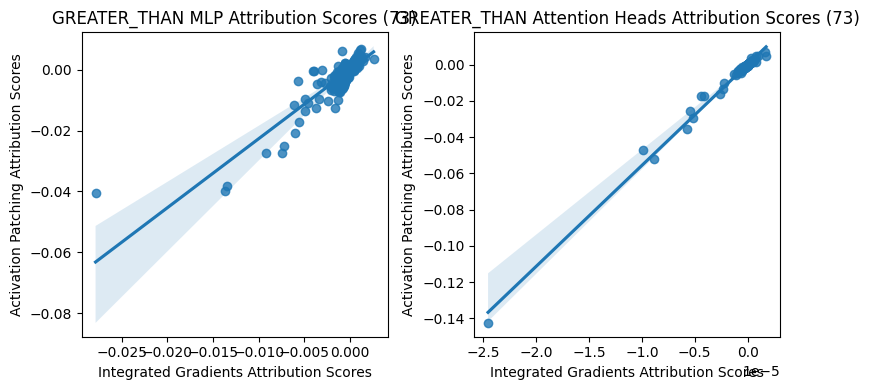

Correlation coefficient for neurons: 0.8765792756976801
Correlation coefficient for attention heads: 0.9945903238289844


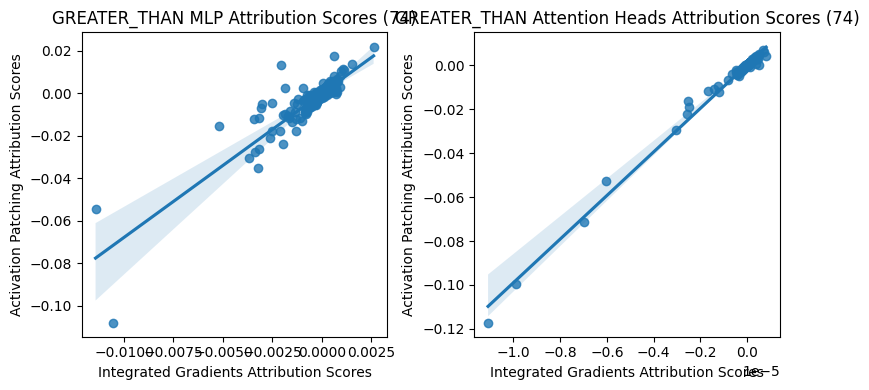

Correlation coefficient for neurons: 0.8857467024006073
Correlation coefficient for attention heads: 0.9945237300848979


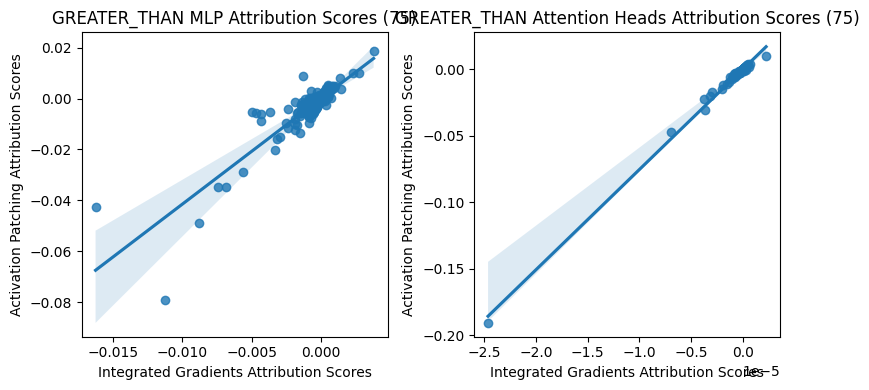

Correlation coefficient for neurons: 0.8873732882453056
Correlation coefficient for attention heads: 0.9965479891558425


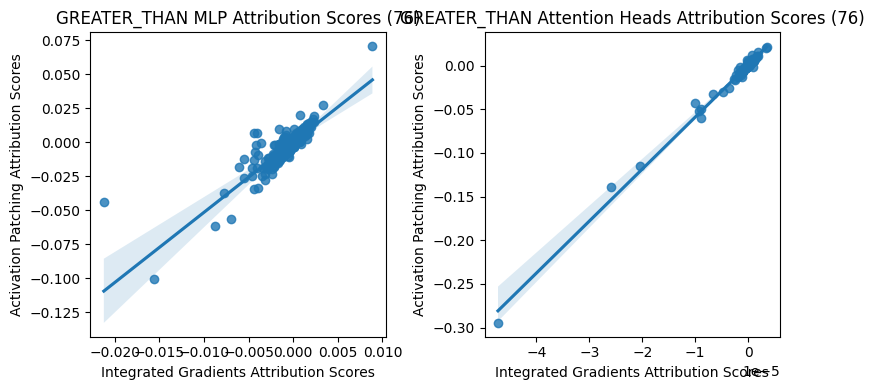

Correlation coefficient for neurons: 0.8782469981565295
Correlation coefficient for attention heads: 0.9950921310690636


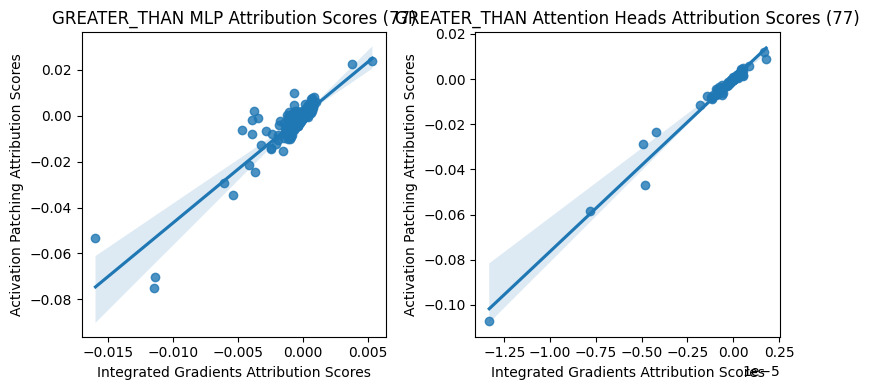

Correlation coefficient for neurons: 0.9010177919319358
Correlation coefficient for attention heads: 0.9898398573783763


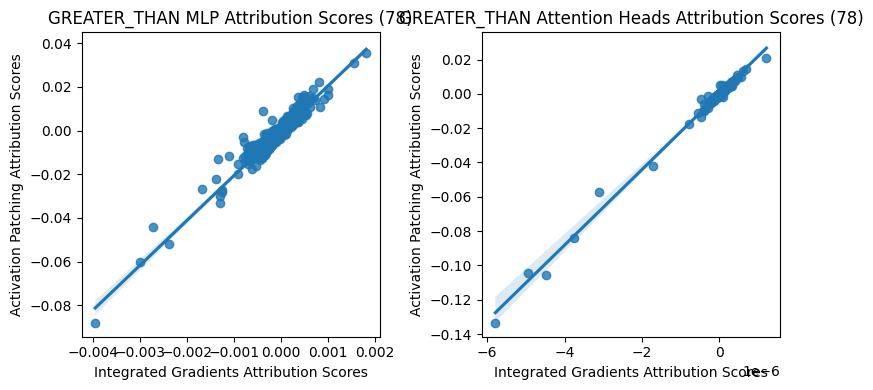

Correlation coefficient for neurons: 0.9567508450407044
Correlation coefficient for attention heads: 0.9953964923068839


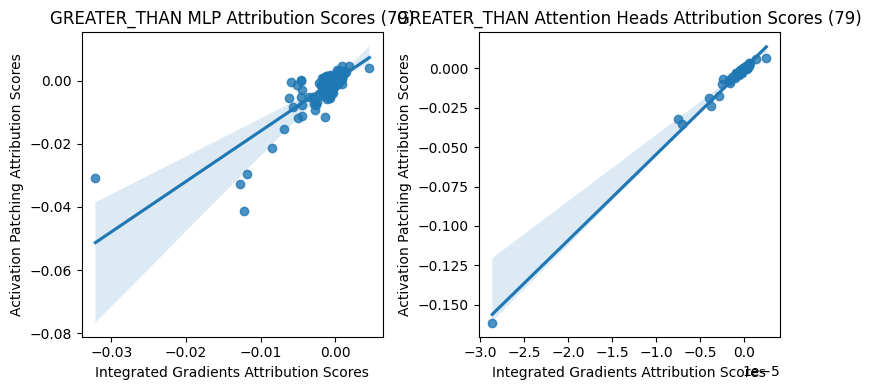

Correlation coefficient for neurons: 0.8167678768275198
Correlation coefficient for attention heads: 0.9947803088310104


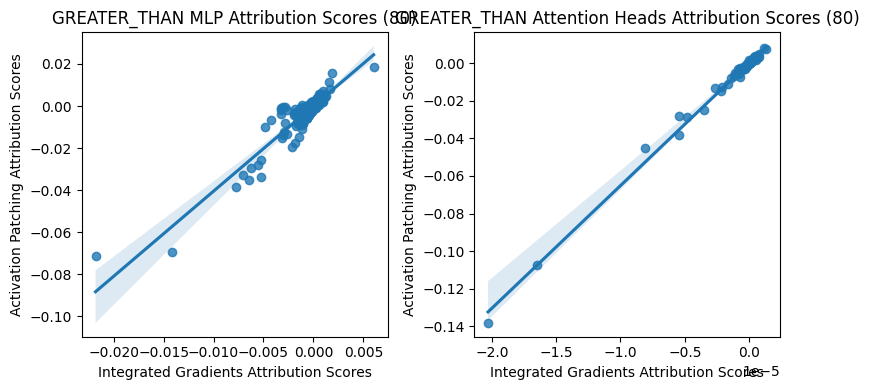

Correlation coefficient for neurons: 0.924132798931989
Correlation coefficient for attention heads: 0.9968315281477973


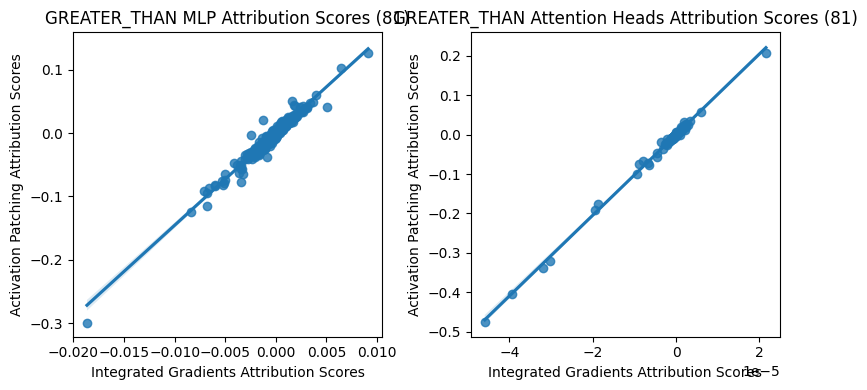

Correlation coefficient for neurons: 0.9816713410518414
Correlation coefficient for attention heads: 0.9982614511521986


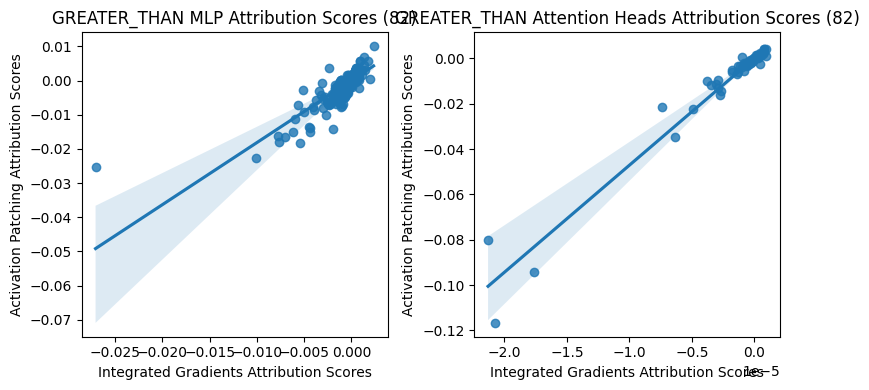

Correlation coefficient for neurons: 0.8123742927450328
Correlation coefficient for attention heads: 0.9781282473013906


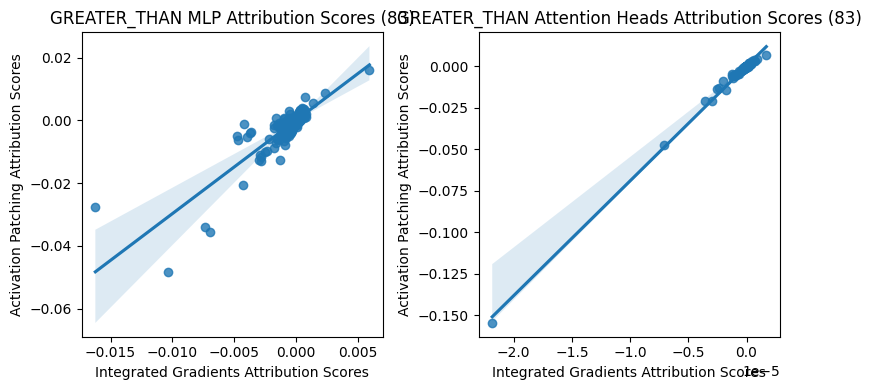

Correlation coefficient for neurons: 0.8520196777043884
Correlation coefficient for attention heads: 0.9969464258950115


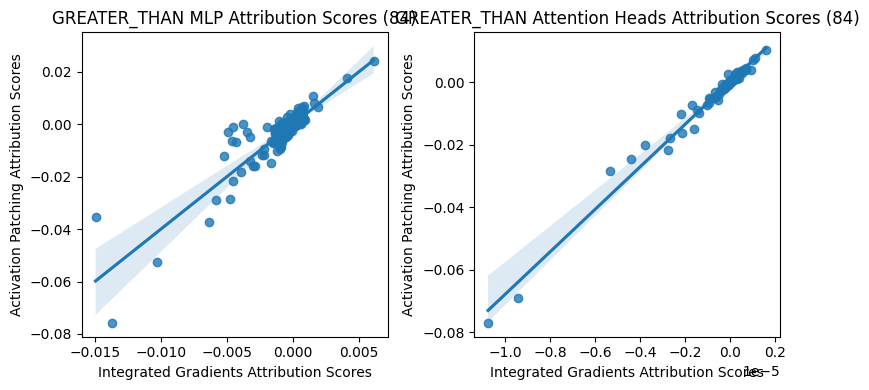

Correlation coefficient for neurons: 0.8858664401439134
Correlation coefficient for attention heads: 0.9906260584755904


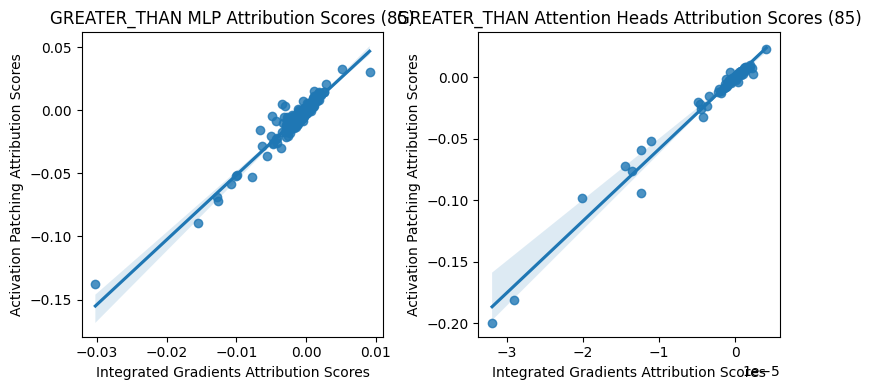

Correlation coefficient for neurons: 0.9597471440267878
Correlation coefficient for attention heads: 0.9899041478498657


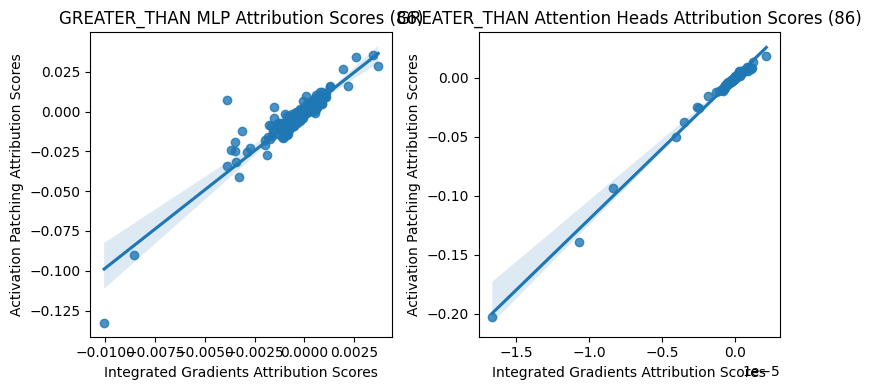

Correlation coefficient for neurons: 0.9313444841050252
Correlation coefficient for attention heads: 0.996434614595962


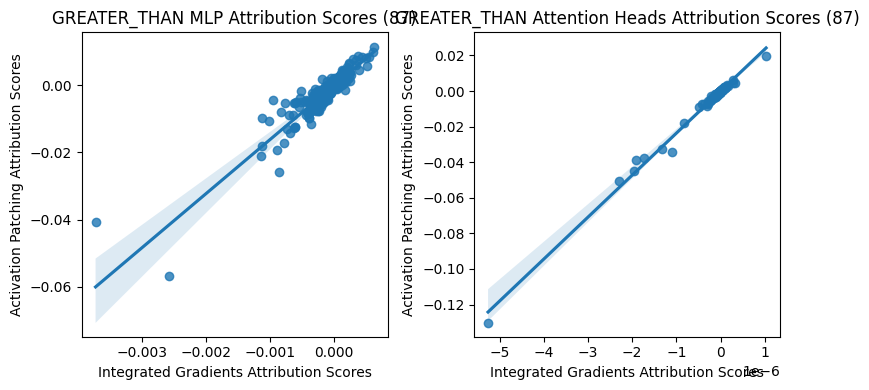

Correlation coefficient for neurons: 0.9174919363441992
Correlation coefficient for attention heads: 0.9951932960063056


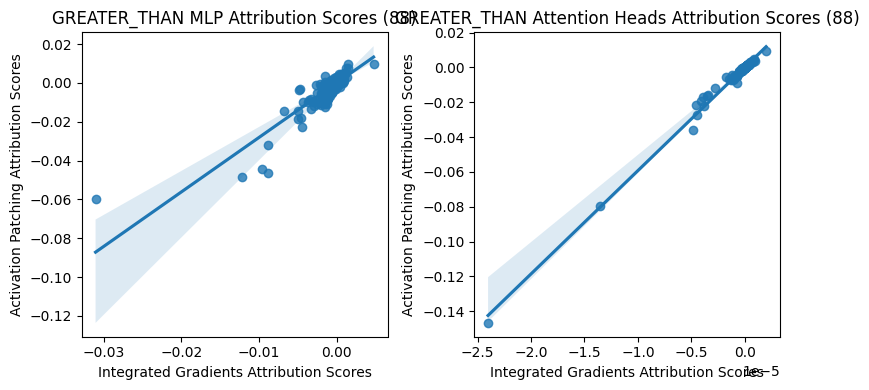

Correlation coefficient for neurons: 0.8799437565143763
Correlation coefficient for attention heads: 0.995183185425296


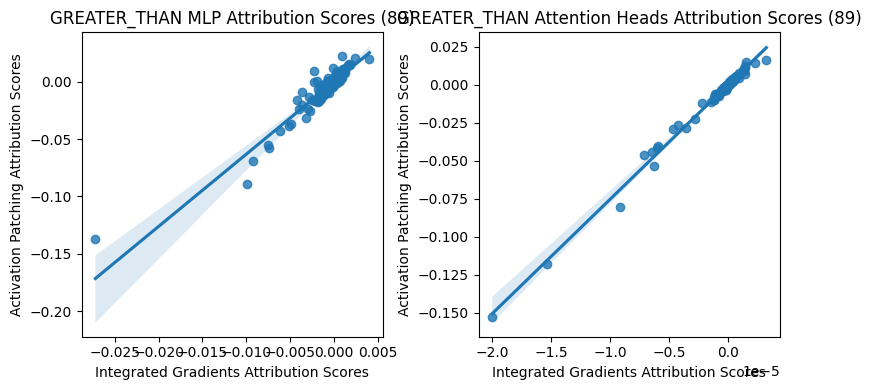

Correlation coefficient for neurons: 0.9454061026823137
Correlation coefficient for attention heads: 0.9952535537587798


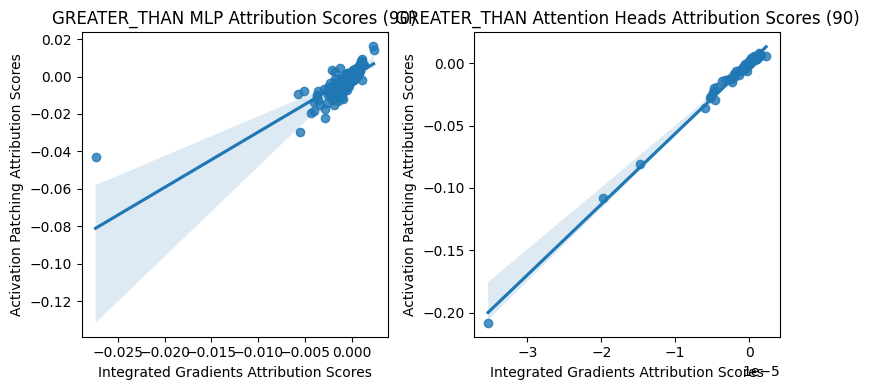

Correlation coefficient for neurons: 0.8035358608676857
Correlation coefficient for attention heads: 0.9963787545774038


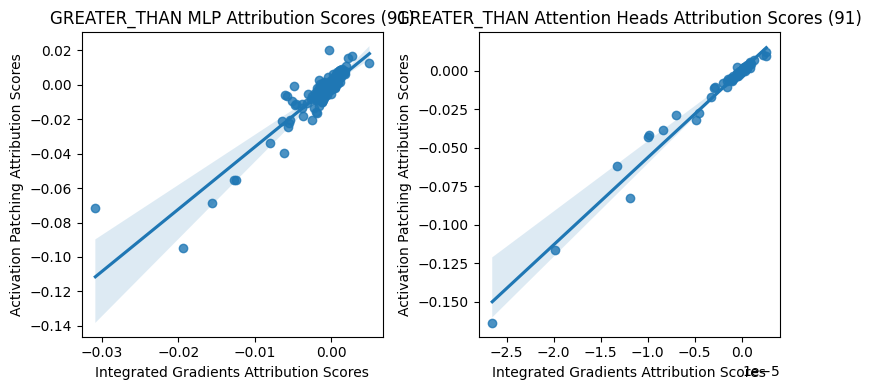

Correlation coefficient for neurons: 0.9095517767999752
Correlation coefficient for attention heads: 0.9877784536221925


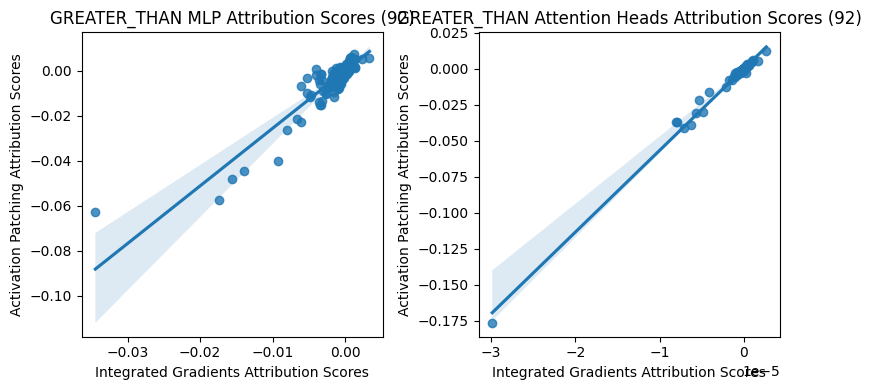

Correlation coefficient for neurons: 0.9044657894523301
Correlation coefficient for attention heads: 0.9943337695174445


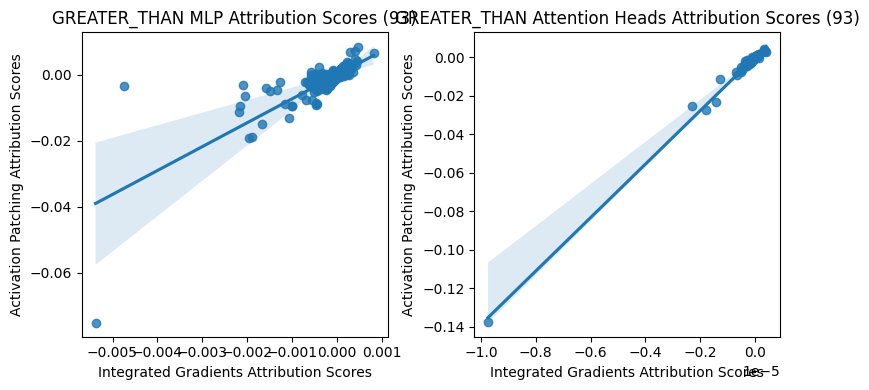

Correlation coefficient for neurons: 0.7905313434307923
Correlation coefficient for attention heads: 0.9961163222589486


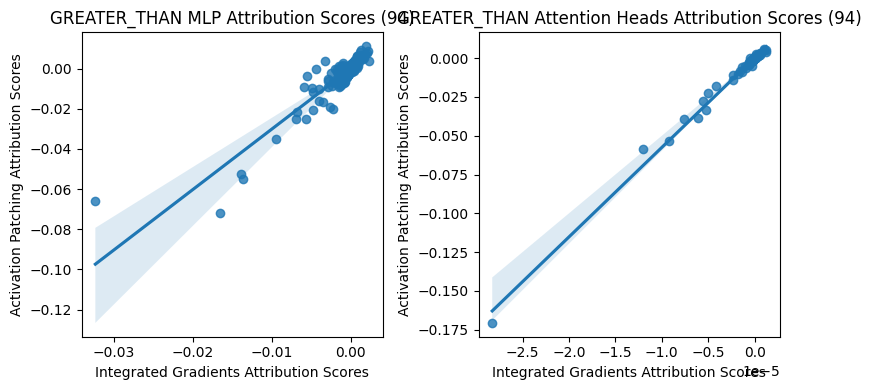

Correlation coefficient for neurons: 0.9015507763484913
Correlation coefficient for attention heads: 0.9953777844045455


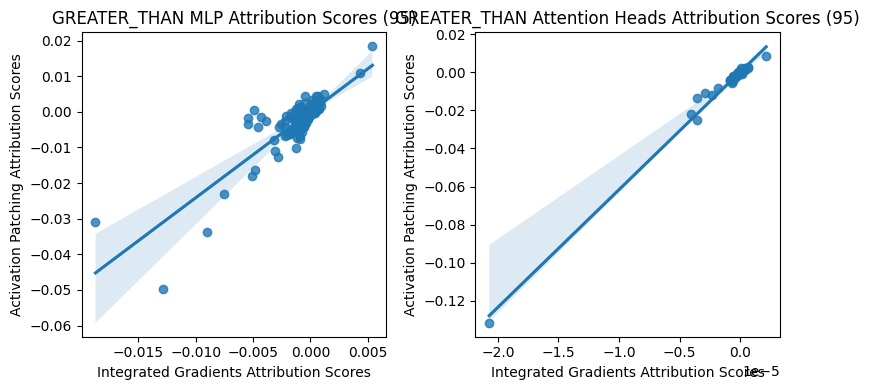

Correlation coefficient for neurons: 0.8545466403467885
Correlation coefficient for attention heads: 0.9941562562250956


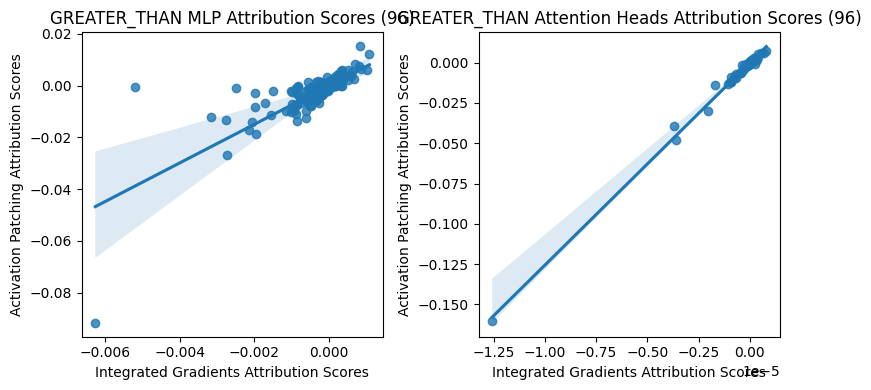

Correlation coefficient for neurons: 0.795252894088443
Correlation coefficient for attention heads: 0.9966890284041889


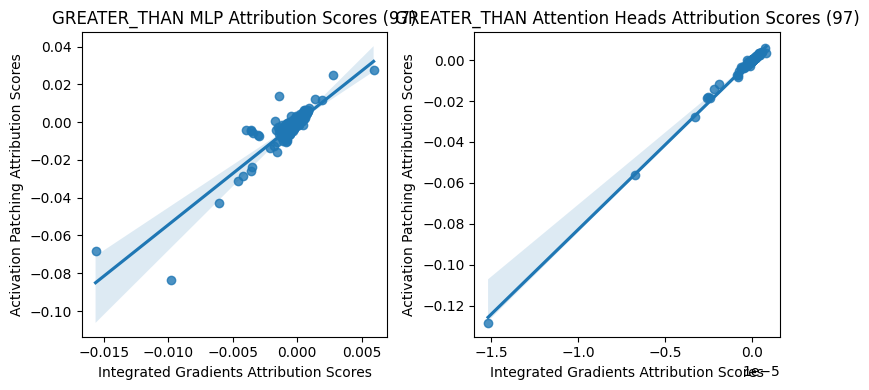

Correlation coefficient for neurons: 0.900237319505318
Correlation coefficient for attention heads: 0.9975943826868707


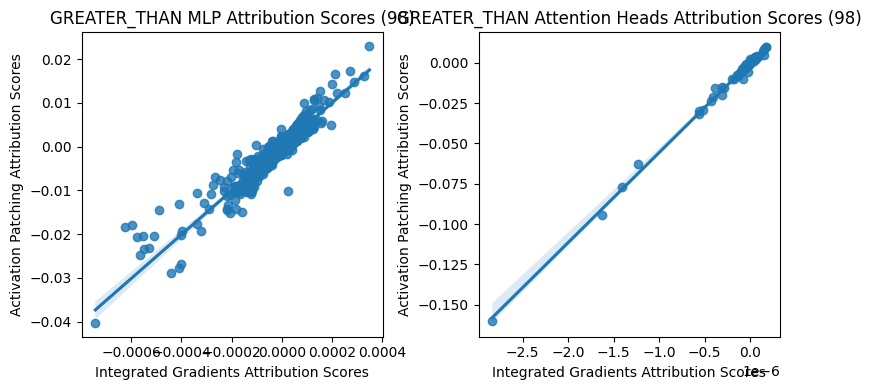

Correlation coefficient for neurons: 0.9438937210285767
Correlation coefficient for attention heads: 0.9979328932227662


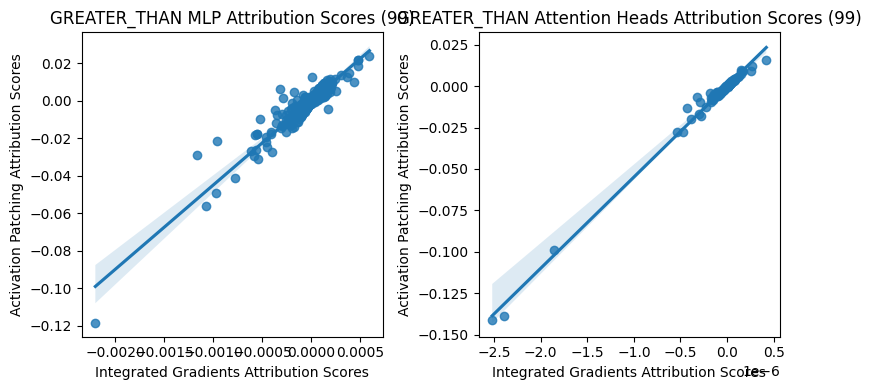

Correlation coefficient for neurons: 0.9393743793077864
Correlation coefficient for attention heads: 0.9949978613778869


In [39]:
plot_correlation_comparison(greater_than_ig_mlp, greater_than_ap_mlp, greater_than_ig_attn, greater_than_ap_attn, Task.GREATER_THAN)

In [40]:
# Test correlation of zero baselines
greater_than_ig_zero_mlp = torch.load("results/aligned/greater_than/ig_zero_mlp.pt")
greater_than_ig_zero_attn = torch.load("results/aligned/greater_than/ig_zero_attn.pt")

print(f"Average absolute correlation between IG and AP neurons for Greater-Than: {average_correlation(greater_than_ig_zero_mlp, greater_than_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Greater-Than: {average_correlation(greater_than_ig_zero_attn, greater_than_ap_attn)}")

Average absolute correlation between IG and AP neurons for Greater-Than: (np.float64(-0.284348642405904), np.float64(0.10390101214647293))
Average absolute correlation between IG and AP attention heads for Greater-Than: (np.float64(-0.10325344420663443), np.float64(0.11978457281392263))


## Capital Country

### Experiment

In [41]:
capital_country_dataset = TaskDataset(Task.CAPITAL_COUNTRY)
capital_country_dataloader = capital_country_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(capital_country_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.8200e+00, -2.5300e+00, -2.0190e+00,  6.3455e+00, -5.2651e-01,
         9.5128e-01,  8.3471e-01, -1.4007e+00,  2.1496e+00, -3.0366e+00,
        -1.9888e+00, -2.4605e+00,  1.8581e+00, -2.1915e+00,  4.4449e-01,
        -2.5304e+00, -1.0142e+00, -4.1187e-01,  1.6885e+00,  7.7189e-01,
        -2.6999e+00, -2.8442e+00, -4.1971e+00,  9.2689e-01,  4.0291e+00,
        -2.2892e+00, -6.7081e-01,  1.0529e+00,  1.0367e+00, -8.7463e-01,
         3.9553e+00,  6.6132e-01,  8.6298e-02, -3.7175e+00, -2.3760e-01,
         3.5704e+00, -2.3199e+00,  1.8338e+00,  3.1291e+00, -1.4578e+00,
         1.1052e-03,  6.2353e+00,  1.2950e+00, -8.1945e-01,  2.0202e-01,
        -2.4481e+00, -4.8091e+00,  1.0870e+00,  7.8114e-01, -3.3017e-01,
         2.4613e+00,  1.4654e+00,  3.8742e-01,  2.1720e+00, -2.4098e-01,
        -1.7736e+00,  1.3818e+00,  4.6563e+00,  7.5080e-01,  1.9365e+00,
        -2.5477e+00, -8.0684e-01, -2.5662e+00, -4.0473e-01, -1.6847e+00,
         3.6113e-01,  1.270

In [12]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

capital_country_ig_zero_mlp, capital_country_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, clean_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_zero_mlp, "results/aligned/capital_country/ig_zero_mlp.pt")
torch.save(capital_country_ig_zero_attn, "results/aligned/capital_country/ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-0.1917,  0.3980, -0.2816,  0.3214, -0.3013,  0.2923, -0.2718, -0.6494,
         0.0577, -0.4184, -0.4827, -0.1438,  0.1642, -0.3908, -0.9039,  0.5107,
         0.2986, -0.2067,  0.1256,  0.3696, -0.3192,  0.0576,  0.7086, -0.2831,
        -1.3181,  0.1825, -0.4915, -0.1708, -0.0896,  0.3967,  0.0611, -0.0170,
         0.1901,  0.1723,  0.0901,  0.1923,  0.5916, -0.6847, -0.6068, -0.1986,
        -0.1749,  0.2538,  0.0022, -0.3537, -0.2048,  0.3793,  0.2387, -0.2132,
        -0.0036, -0.0561, -0.0864, -0.0222, -0.3336,  0.2562,  0.6979, -0.5946,
        -0.2094, -0.3889,  0.4215,  0.2833,  0.2883, -0.0283, -0.0277,  0.0173,
         0.4280,  0.0100,  0.0504,  0.0490,  0.2642, -0.2463, -0.2530,  0.2759,
         0.0323,  0.0546, -0.3910,  0.1747, -0.4148,  0.1700, -0.1277,  0.3499,
         0.0371,  0.2155, -0.2010, -0.0442,  0.0616,  0.0406, -0.3375, -0.3777,
         0.2400,  0.3805,  0.1999,  0.7340,  0.3050,  0.0041, 

In [42]:
capital_country_ig_mlp, capital_country_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_mlp, "results/aligned/capital_country/ig_mlp.pt")
torch.save(capital_country_ig_attn, "results/aligned/capital_country/ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-6.6403e-07, -1.7583e-06,  1.2144e-06,  1.8001e-05,  5.1148e-06,
        -1.2573e-07,  1.6764e-07,  2.0154e-06,  2.4308e-06, -2.6897e-06,
        -1.6913e-06,  6.1095e-07,  4.9360e-08,  2.1271e-06,  9.6112e-07,
        -1.2275e-06, -1.2033e-06,  7.4301e-06, -6.7800e-07, -2.5220e-06,
         3.2233e-06, -7.3761e-07,  2.3171e-06,  1.6652e-06, -1.6689e-05,
         9.3505e-07, -5.8115e-07, -1.1993e-06, -1.6950e-06,  2.2026e-07,
         1.5069e-06,  6.8918e-07, -1.8319e-06, -1.1772e-06, -3.1330e-06,
         9.2667e-07, -8.4192e-07, -1.8664e-06,  2.3469e-07,  3.3230e-06,
         1.7732e-06, -2.5332e-06, -3.0734e-07, -2.9281e-06, -3.5614e-06,
         2.0694e-06,  1.0878e-06, -4.7386e-06,  1.7807e-06,  1.8999e-07,
        -4.0047e-06, -2.3954e-06,  1.2927e-06, -1.3560e-06, -6.5472e-07,
         2.0117e-07, -9.5181e-07, -7.4506e-07,  1.6410e-06,  8.0094e-07,
        -1.5944e-06, -2.4289e-06,  8.9407e-08, -2.0303e-07,  3.743

In [43]:
capital_country_ap_mlp, capital_country_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(capital_country_ap_mlp, "results/aligned/capital_country/ap_mlp.pt")
torch.save(capital_country_ap_attn, "results/aligned/capital_country/ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

### Analysis

In [44]:
capital_country_ig_mlp = torch.load("results/aligned/capital_country/ig_mlp.pt")
capital_country_ig_attn = torch.load("results/aligned/capital_country/ig_attn.pt")
capital_country_ap_mlp = torch.load("results/aligned/capital_country/ap_mlp.pt")
capital_country_ap_attn = torch.load("results/aligned/capital_country/ap_attn.pt")

In [45]:
print_jaccard_multi(capital_country_ig_mlp, capital_country_ig_attn, capital_country_ap_mlp, capital_country_ap_attn)

Average Jaccard similarity score for MLP: 0.8333046436309814
Average Jaccard similarity score for Attention: 0.9315417408943176
Jaccard similarity std for MLP: 0.12327081710100174
Jaccard similarity std for Attention: 0.20756983757019043


In [46]:
capital_country_ig_zero_mlp = torch.load("results/aligned/capital_country/ig_zero_mlp.pt")
capital_country_ig_zero_attn = torch.load("results/aligned/capital_country/ig_zero_attn.pt")

print("For zero baseline:")
print_jaccard_multi(capital_country_ig_zero_mlp, capital_country_ig_zero_attn, capital_country_ap_mlp, capital_country_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.1478511542081833
Average Jaccard similarity score for Attention: 0.2983318567276001
Jaccard similarity std for MLP: 0.03893262892961502
Jaccard similarity std for Attention: 0.4207219183444977


In [ ]:
plot_correlation_comparison(capital_country_ig_mlp, capital_country_ap_mlp, capital_country_ig_attn, capital_country_ap_attn, Task.CAPITAL_COUNTRY)

In [47]:

print(f"Average absolute correlation between IG and AP neurons for Capital-Country: {average_correlation(capital_country_ig_mlp, capital_country_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Capital-Country: {average_correlation(capital_country_ig_attn, capital_country_ap_attn)}")

Average absolute correlation between IG and AP neurons for Capital-Country: (np.float64(0.6519729627536308), np.float64(0.6756591357188685))
Average absolute correlation between IG and AP attention heads for Capital-Country: (np.float64(0.6969040447091495), np.float64(0.7085664330459217))


In [48]:
# Test correlation of zero baselines
capital_country_ig_zero_mlp = torch.load("results/aligned/capital_country/ig_zero_mlp.pt")
capital_country_ig_zero_attn = torch.load("results/aligned/capital_country/ig_zero_attn.pt")

print(f"Average absolute correlation between IG and AP neurons for Capital-Country: {average_correlation(capital_country_ig_zero_mlp, capital_country_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Capital-Country: {average_correlation(capital_country_ig_zero_attn, capital_country_ap_attn)}")

Average absolute correlation between IG and AP neurons for Capital-Country: (np.float64(-0.02916161810661147), np.float64(0.08560643112091945))
Average absolute correlation between IG and AP attention heads for Capital-Country: (np.float64(-0.04224946520456683), np.float64(0.12549349629542322))


## Gender Bias

### Experiment

In [49]:
gender_bias_dataset = TaskDataset(Task.GENDER_BIAS)
gender_bias_dataloader = gender_bias_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(gender_bias_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.4348, -1.5338,  1.4572,  1.4659,  1.4542,  1.3636,  1.4376,  1.5102,
        -1.4453,  0.6453,  1.4408,  1.5409,  1.9085,  1.5206,  3.2713,  1.2645,
        -1.4762,  1.5827, -0.1731, -1.2693,  1.8740,  1.5169,  1.5449,  1.2635,
         1.5521, -1.4228, -1.5192, -1.4169, -1.3915, -1.4274,  1.8045,  3.1738,
        -1.4906,  1.5187, -1.5254,  1.4072,  1.4378, -1.3723,  1.4582,  1.5068,
        -1.5435, -1.4447,  2.2557, -1.4185,  1.4803,  1.3989, -1.4231,  1.5833,
         1.5432,  1.5064, -1.2827,  1.5562, -1.4473,  2.3805,  0.6395, -1.3349,
        -1.3978,  3.3997,  1.4925,  0.7471,  2.1428,  1.5288, -1.4112, -1.2596,
        -1.4297,  2.2779, -1.4844,  1.5051,  1.5515,  1.4641, -1.5070,  1.5229,
        -1.4662,  1.5414,  1.5559,  0.9713, -1.4052,  1.4867,  3.9474,  1.5111,
        -1.4275,  1.4870, -1.5117,  1.4568, -0.9252,  1.4716, -1.4398, -1.4266,
         2.5784, -1.3107, -1.3026,  1.4261,  1.4988, -1.3030,  1.5269,  1.5192,
        -1.4368,

In [14]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

gender_bias_ig_zero_mlp, gender_bias_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, clean_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_zero_mlp, "results/aligned/gender_bias/ig_zero_mlp.pt")
torch.save(gender_bias_ig_zero_attn, "results/aligned/gender_bias/ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 9.1067e-01,  6.4025e-02, -9.3638e-02, -1.5100e-01,  9.7434e-02,
        -1.7810e+00,  7.5962e-02,  4.8798e-02, -3.9255e-02,  1.2669e+00,
        -9.6353e-02,  9.1521e-02, -3.9385e-01,  1.5358e-01, -1.2570e+00,
        -1.9237e+00, -2.7311e-01, -1.0502e-01, -8.2718e-01, -8.9908e-02,
        -8.7136e-01, -1.2872e-01, -3.2759e-01, -7.6822e-02, -7.3437e-02,
         4.2908e-03,  1.1864e-01,  5.4029e-02, -3.4393e-01,  1.0764e-02,
        -1.2526e+00,  3.1297e-01, -1.6400e-02, -1.8412e-01,  4.1036e-02,
        -1.9140e-01, -3.1947e-02, -3.2681e-02, -2.2134e-01, -6.3136e-01,
         1.0844e-01,  1.6092e-02,  1.4670e-01,  4.8974e-02, -1.4740e-02,
         4.3073e-01, -6.0281e-02,  5.1182e-02, -6.0606e-02,  3.7833e-01,
         1.8564e-01,  5.6090e-03,  1.2642e-01, -1.2720e+00, -9.2929e-02,
         1.0448e-01,  5.8752e-02, -1.5239e+00,  1.8502e-02,  2.2137e+00,
        -2.9553e-01,  7.9741e-02,  1.9131e-01,  1.6017e-01,  1.179

In [50]:
gender_bias_ig_mlp, gender_bias_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_mlp, "results/aligned/gender_bias/ig_mlp.pt")
torch.save(gender_bias_ig_attn, "results/aligned/gender_bias/ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 1.5885e-05, -1.3150e-06,  9.3691e-07, -6.8825e-07,  9.9838e-07,
        -9.6262e-06, -1.0999e-06,  3.4273e-07,  2.9057e-07,  2.8014e-06,
         2.1048e-07, -7.7114e-07,  6.2585e-06,  8.3912e-07,  3.5763e-07,
        -2.5630e-06, -9.5414e-07, -8.4937e-07, -2.1696e-05, -8.0466e-07,
         1.5318e-05,  1.5078e-06,  4.8429e-07,  7.8976e-06, -2.6301e-06,
        -1.3039e-07,  3.5018e-07, -2.5984e-07,  5.9605e-08,  3.6880e-07,
        -7.8678e-06,  1.0535e-05, -7.4133e-07,  2.2482e-06, -9.5926e-08,
        -7.6368e-07, -9.7789e-08, -5.7742e-08,  7.5251e-07, -1.2934e-05,
        -8.4098e-07, -7.4506e-08,  5.5432e-06, -1.2415e-06, -1.6391e-06,
        -5.8115e-07,  5.5321e-07, -2.6263e-07,  6.2212e-07,  5.8860e-07,
         5.0664e-07,  6.2771e-07,  1.0021e-06,  2.0862e-06, -9.7752e-06,
        -2.0536e-07,  8.7731e-07,  9.8944e-06, -1.5646e-07,  3.5763e-07,
        -9.8944e-06,  1.5516e-06, -1.0133e-06,  6.2212e-07, -1.415

In [51]:
gender_bias_ap_mlp, gender_bias_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(gender_bias_ap_mlp, "results/aligned/gender_bias/ap_mlp.pt")
torch.save(gender_bias_ap_attn, "results/aligned/gender_bias/ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

### Analysis

In [52]:
gender_bias_ig_mlp = torch.load("results/aligned/gender_bias/ig_mlp.pt")
gender_bias_ig_attn = torch.load("results/aligned/gender_bias/ig_attn.pt")
gender_bias_ap_mlp = torch.load("results/aligned/gender_bias/ap_mlp.pt")
gender_bias_ap_attn = torch.load("results/aligned/gender_bias/ap_attn.pt")

In [53]:
print_jaccard_multi(gender_bias_ig_mlp, gender_bias_ig_attn, gender_bias_ap_mlp, gender_bias_ap_attn)

Average Jaccard similarity score for MLP: 0.8214888572692871
Average Jaccard similarity score for Attention: 0.941236138343811
Jaccard similarity std for MLP: 0.1197245642542839
Jaccard similarity std for Attention: 0.20532774925231934


In [54]:
gender_bias_ig_zero_mlp = torch.load("results/aligned/gender_bias/ig_zero_mlp.pt")
gender_bias_ig_zero_attn = torch.load("results/aligned/gender_bias/ig_zero_attn.pt")
print("For zero baseline:")
print_jaccard_multi(gender_bias_ig_zero_mlp, gender_bias_ig_zero_attn, gender_bias_ap_mlp, gender_bias_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.1627115160226822
Average Jaccard similarity score for Attention: 0.25722014904022217
Jaccard similarity std for MLP: 0.05521421134471893
Jaccard similarity std for Attention: 0.38952797651290894


In [ ]:
plot_correlation_comparison(gender_bias_ig_mlp, gender_bias_ap_mlp, gender_bias_ig_attn, gender_bias_ap_attn, Task.GENDER_BIAS)

In [55]:
print(f"Average absolute correlation between IG and AP neurons for Gender-Bias: {average_correlation(gender_bias_ig_mlp, gender_bias_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Gender-Bias: {average_correlation(gender_bias_ig_attn, gender_bias_ap_attn)}")

Average absolute correlation between IG and AP neurons for Gender-Bias: (np.float64(0.87334359287431), np.float64(0.3210200017530308))
Average absolute correlation between IG and AP attention heads for Gender-Bias: (np.float64(0.9394814623891503), np.float64(0.3410210043552813))


In [56]:
# Test correlation of zero baselines
gender_bias_ig_zero_mlp = torch.load("results/aligned/gender_bias/ig_zero_mlp.pt")
gender_bias_ig_zero_attn = torch.load("results/aligned/gender_bias/ig_zero_attn.pt")

print(f"Average absolute correlation between IG and AP neurons for Gender-Bias: {average_correlation(gender_bias_ig_zero_mlp, gender_bias_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Gender-Bias: {average_correlation(gender_bias_ig_zero_attn, gender_bias_ap_attn)}")

Average absolute correlation between IG and AP neurons for Gender-Bias: (np.float64(-0.02639734268709969), np.float64(0.15334180645491477))
Average absolute correlation between IG and AP attention heads for Gender-Bias: (np.float64(-0.05267033128886257), np.float64(0.12437801344569209))
